In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [3]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [4]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

## Distance modulus

In [5]:
# SN metadata

z = 0.02736
z_unc = 0.00007
t_max_mjd = 59722.75 # t_max_B
ebv = 0.032
rv = 3.1

# tfl = 58972.46296299994


In [6]:
cosmo = np.loadtxt('SN2022joj_cosmo.txt')
print('Luminosity distances =', cosmo[6], 'Mpc')

distmod = 5 * np.log10(cosmo[6] * 1e6 / 10)
print('Distance modulus = {:.2f}'.format(distmod))


Luminosity distances = 119.49 Mpc
Distance modulus = 35.39


## Light curves

In [7]:
import pandas as pd
from astropy.table import Table

In [8]:
joj_ZTF = pd.read_csv('./ZTF22aajijjf_forced_fnu.csv')
joj_ZTF['MJD'] = joj_ZTF['jd'] - 2400000.5
joj_ZTF['phase'] = (joj_ZTF['MJD'] - t_max_mjd) / (1 + z)
joj_ZTF['fnu_microJy'] = joj_ZTF['fnu_microJy'] * (1 + z)
joj_ZTF['fnu_microJy_unc'] = joj_ZTF['fnu_microJy_unc'] * (1 + z)
arg = (joj_ZTF['phase'] <= 150) & (joj_ZTF['phase'] >= -25)
joj_ZTF = joj_ZTF[arg]
joj_ZTF['mag'] = -2.5 * np.log10(joj_ZTF['fnu_microJy'] * 1e-6/3631)
joj_ZTF['mag_err_u'] = -2.5 * np.log10((joj_ZTF['fnu_microJy'] - joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) - joj_ZTF['mag']
joj_ZTF['mag_err_l'] = 2.5 * np.log10((joj_ZTF['fnu_microJy'] + joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) + joj_ZTF['mag']
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ZTF_g'].assign(passband='ztfg')
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ZTF_r'].assign(passband='ztfr')
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ZTF_i'].assign(passband='ztfi')
joj_ZTF = pd.concat([joj_ZTF_g, joj_ZTF_r, joj_ZTF_i])


/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# joj_ZTF = joj_ZTF[~np.isnan(joj_ZTF['mag'])]
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ztfg']
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ztfr']
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ztfi']

## 1-D DDet models

In [10]:
import h5py

spec1 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220511_FTN_FLOYDS-N_Global_SN_Project.ascii')
spec1 = data_binning(np.array([spec1[:, 0], spec1[:, 1], np.ones_like(spec1[:, 0])]).T, size=5)
spec2 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220526_SEDM_1.txt')
spec3 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220601_NOT_ALFOSC.ascii')

### Polin+2019

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.625


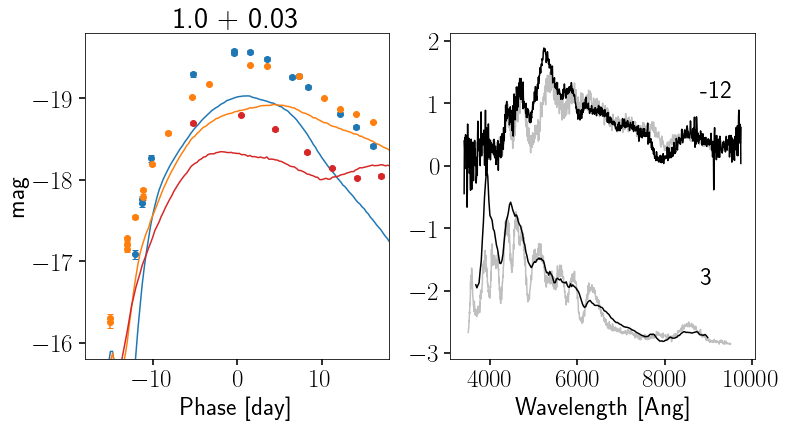

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


15.875


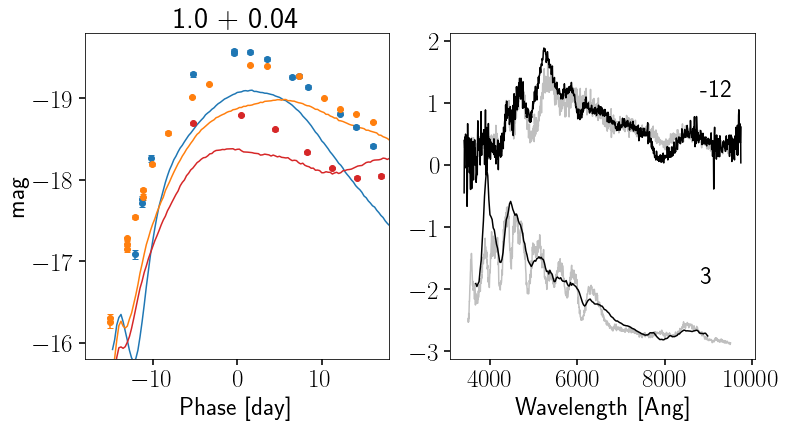

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


14.875


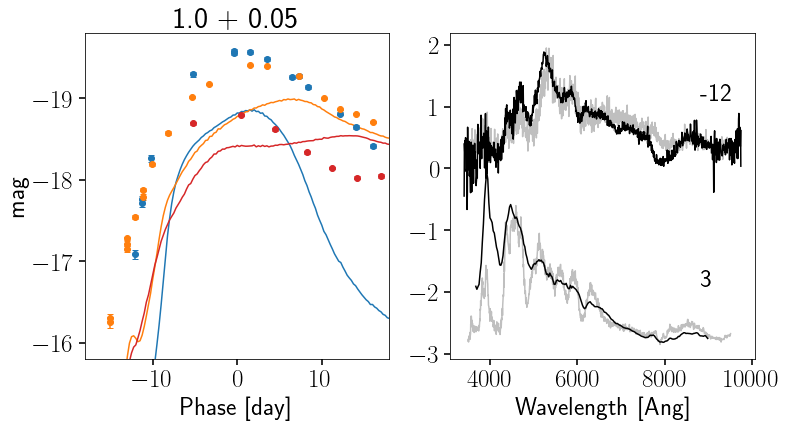

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.875


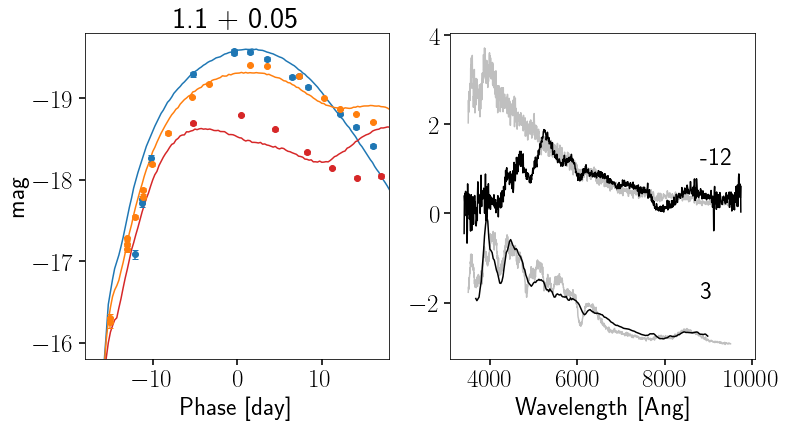

In [16]:
models = sorted(
    glob.glob(
        "/Users/chang/Desktop/SNIa/DoubleDetonationModels/Polin2019/spectra/good_1.[0-1]*"
    )
)
filters = sorted(glob.glob("./filters/P48*"))

for model in models:
    mod = model.split("/")[-1]
    mc, ms = mod.split("_")[-3], mod.split("_")[-2]
    if (float(ms) < 0.03) or (float(ms) > 0.05):
        continue
    with h5py.File(model, "r") as f:
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = np.array(
            [
                (np.flip(fnu)).to(
                    u.erg / u.s / u.cm**2 / u.AA,
                    equivalencies=u.spectral_density(wv * u.AA),
                )
                for fnu in Fnu
            ]
        ) / (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    for k, fl in enumerate(Flam[ind]):
        fit_i[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
        )[0]
        fit_r[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
        )[0]
        fit_g[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
        )[0]
        fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
    t_max = time[ind][np.argmin(fit_B)]
    print(t_max)
    # t_max = 17

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(time[ind] - t_max, fit_g, color="tab:blue")
    ax[0].plot(time[ind] - t_max, fit_r, color="tab:orange")
    ax[0].plot(time[ind] - t_max, fit_i, color="tab:red")

    ax[0].errorbar(
        (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
        joj_ZTF_g["mag"] - distmod,
        yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
        fmt="o",
        capsize=3,
        color="tab:blue",
    )
    ax[0].errorbar(
        (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
        joj_ZTF_r["mag"] - distmod,
        yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
        fmt="o",
        capsize=3,
        color="tab:orange",
    )
    ax[0].errorbar(
        (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
        joj_ZTF_i["mag"] - distmod,
        yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
        fmt="o",
        capsize=3,
        color="tab:red",
    )
    ax[0].invert_yaxis()
    ax[0].set_ylim(-15.8, -19.8)
    ax[0].set_xlim(-18, 18)
    ax[0].set_xlabel("Phase [day]")
    ax[0].set_ylabel("mag")
    ax[0].set_title(f"{mc} + {ms}")

    idx_wv = (wv0 > 3500) & (wv0 < 9500)
    phases = np.array([-12.1, 2.52])
    specs = [spec1, spec2]
    for k in range(2):
        phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
        ax[1].plot(
            wv0[idx_wv],
            Flam[phase_idx][idx_wv]
            / np.median(Flam[phase_idx][(wv0 > 5500) & (wv0 < 6500)])
            - 3 * k,
            color=".5",
            alpha=0.5,
        )
        ax[1].plot(
            specs[k][:, 0] / (1 + z),
            specs[k][:, 1]
            / np.median(
                specs[k][:, 1][
                    (specs[k][:, 0] / (1 + z) > 5500)
                    & (specs[k][:, 0] / (1 + z) < 6500)
                ]
            )
            - 3 * k,
            color="k",
        )
        ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 3 * k, color="k")
    ax[1].set_xlabel("Wavelength [Ang]")
    plt.show()

In [17]:
models = sorted(
    glob.glob(
        "/Users/chang/Desktop/SNIa/DoubleDetonationModels/Polin2019/spectra/good_1.[0-1]*"
    )
)
filters = sorted(glob.glob("./filters/*P48*"))

for model in models:
    mod = model.split("/")[-1]
    mc, ms = mod.split("_")[-3], mod.split("_")[-2]
    if (float(ms) < 0.03) or (float(ms) > 0.05):
        continue
    with h5py.File(model, "r") as f:
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = np.array(
            [
                (np.flip(fnu)).to(
                    u.erg / u.s / u.cm**2 / u.AA,
                    equivalencies=u.spectral_density(wv * u.AA),
                )
                for fnu in Fnu
            ]
        ) / (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    for k, fl in enumerate(Flam[ind]):
        fit_i[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
        )[0]
        fit_r[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
        )[0]
        fit_g[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
        )[0]
        fit_B[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)],
            flt=np.loadtxt("./filters/Bessell_B.dat"),
        )[0]
    t_max = time[ind][np.argmin(fit_B)]
    print(t_max)
    np.savetxt(
        f"./Polin+19_model/mc_{mc}_ms_{ms}_lc.txt",
        np.array([time[ind], fit_g, fit_r, fit_i, fit_B]).T,
        fmt="%.2f %.3f %.3f %.3f %.3f",
        header="Time ZTFg ZTFr ZTFi B",
    )

    idx_wv = (wv0 > 3000) & (wv0 < 9500)
    phases = np.array([-13, -12, -11, 0, 1, 2, 3])
    for k in range(len(phases)):
        phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
        np.savetxt(
            f"./Polin+19_model/mc_{mc}_ms_{ms}_phase_{phases[k]}_spec.txt",
            np.array(
                [
                    wv,
                    Flam[phase_idx],  # 10 pc --> D_L Mpc
                ]
            ).T[idx_wv, :],
            fmt="%.4f %.4e",
            header="time_explosion = {}\n".format(time[phase_idx]),
        )

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.625
15.875
14.875
16.875


### Shen+2021

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


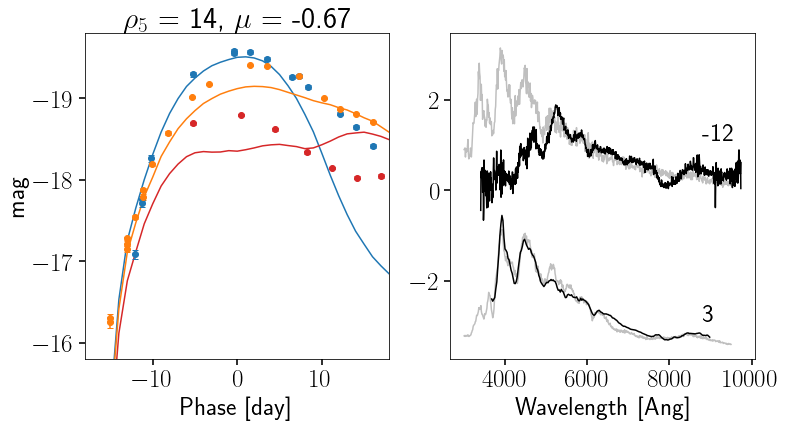

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


15.25


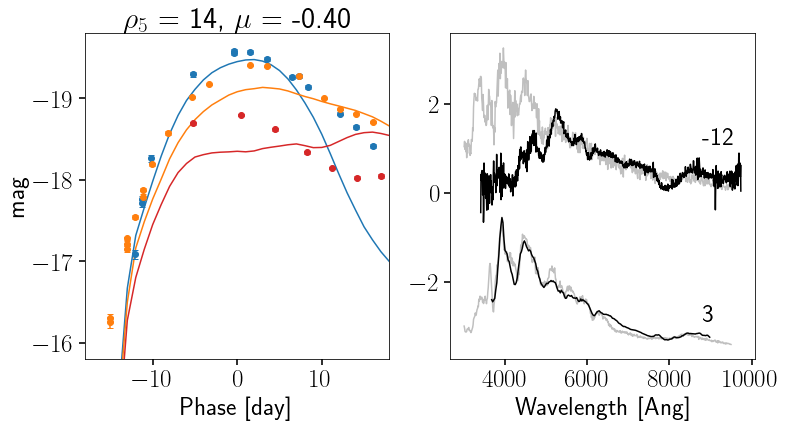

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


15.25


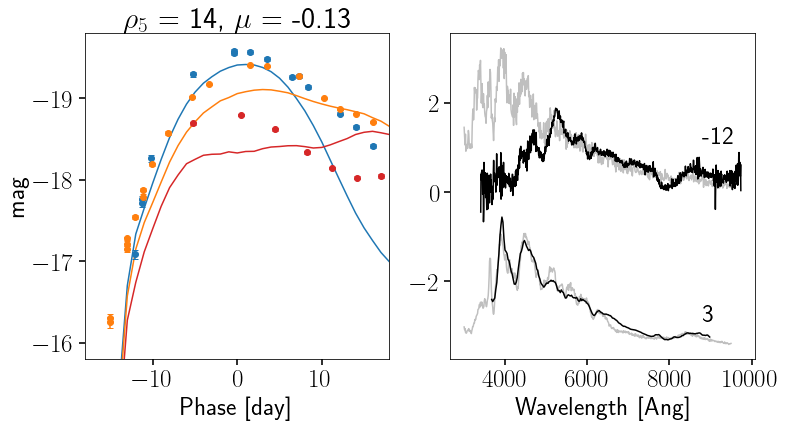

In [18]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.0_??e5.h5"))
filters = sorted(glob.glob("./filters/*P48*"))

for model in models:
    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    fit_B = np.empty_like(time[ind][::2])
    for i in [2, 4, 6]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        t_max = time[ind][::2][np.argmin(fit_B)]
        print(t_max)
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color="tab:blue")
        ax[0].plot(time[ind][::2] - t_max, fit_r, color="tab:orange")
        ax[0].plot(time[ind][::2] - t_max, fit_i, color="tab:red")
        ax[0].errorbar(
            (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_g["mag"] - distmod,
            yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:blue",
        )
        ax[0].errorbar(
            (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_r["mag"] - distmod,
            yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:orange",
        )
        ax[0].errorbar(
            (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_i["mag"] - distmod,
            yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:red",
        )
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel("Phase [day]")
        ax[0].set_ylabel("mag")
        ax[0].set_title(r"$\rho_5$ = {}, $\mu$ = {:.2f}".format(rho, cos_theta[i]))

        phases = np.array([-12.1, 2.52])
        specs = [spec1, spec2]
        for k in range(2):

            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 9500)
            Flam_bin = data_binning(
                np.array(
                    [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]
                ).T,
                size=10,
            )
            ax[1].plot(
                Flam_bin[:, 0],
                Flam_bin[:, 1]
                / np.median(
                    Flam_bin[(Flam_bin[:, 0] > 5500) & (Flam_bin[:, 0] < 6500), 1]
                )
                - 3.5 * k,
                color=".5",
                alpha=0.5,
            )
            ax[1].plot(
                specs[k][:, 0] / (1 + z),
                specs[k][:, 1]
                / np.median(
                    specs[k][:, 1][
                        (specs[k][:, 0] / (1 + z) > 5500)
                        & (specs[k][:, 0] / (1 + z) < 6500)
                    ]
                )
                - 3.5 * k,
                color="k",
            )
            ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 4 * k, color="k")
        ax[1].set_xlabel("Wavelength [Ang]")
        plt.show()

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


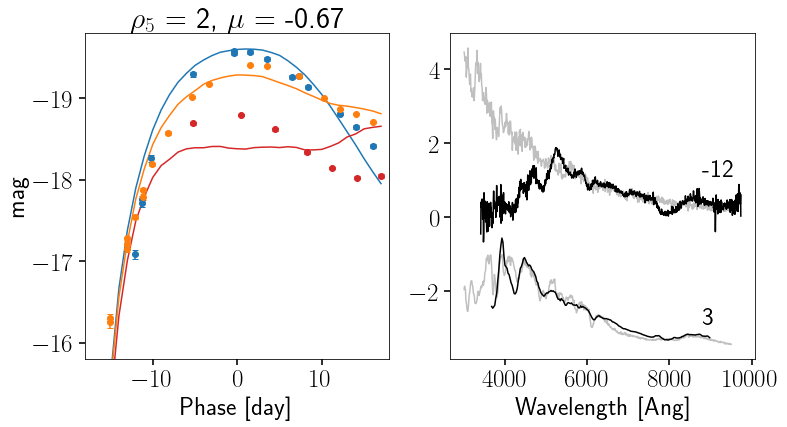

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


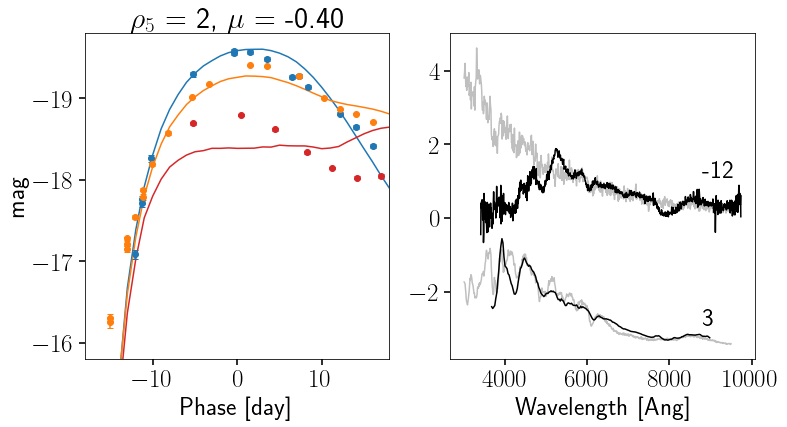

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


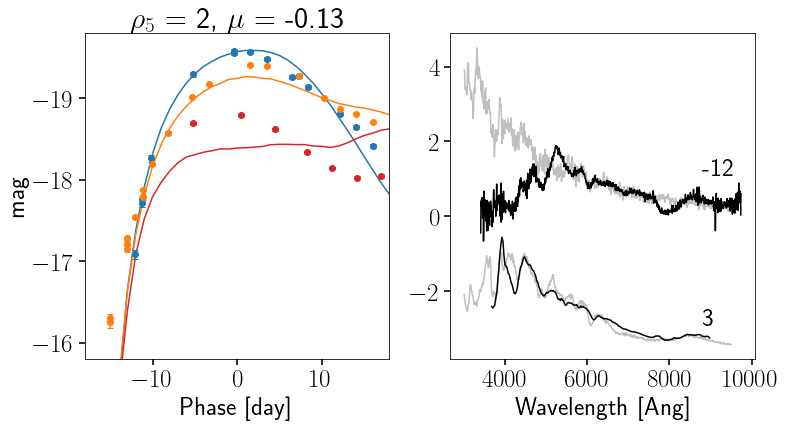

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


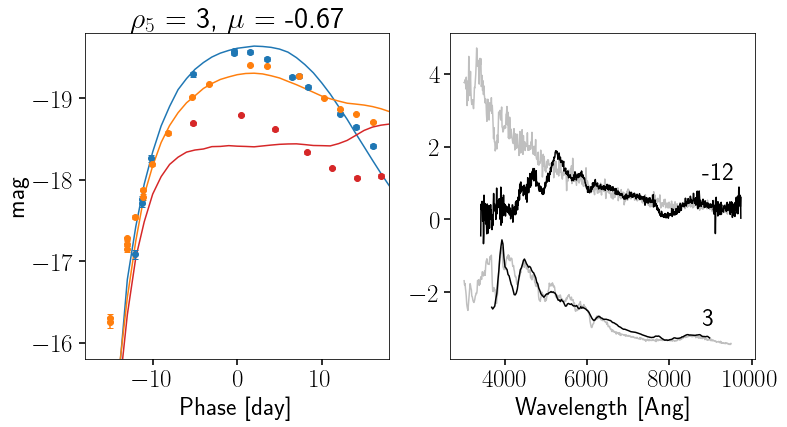

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


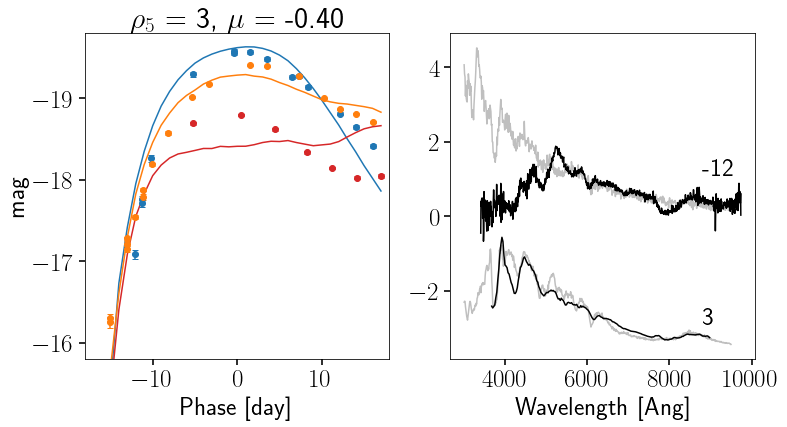

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


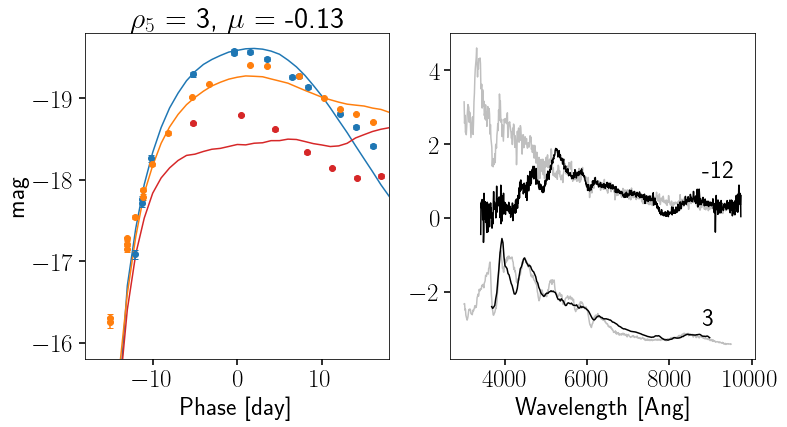

In [19]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.10_*e5.h5"))
filters = sorted(glob.glob("./filters/*P48*"))

for model in models:
    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    fit_B = np.empty_like(time[ind][::2])
    for i in [2, 4, 6]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        t_max = time[ind][::2][np.argmin(fit_B)]
        print(t_max)
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color="tab:blue")
        ax[0].plot(time[ind][::2] - t_max, fit_r, color="tab:orange")
        ax[0].plot(time[ind][::2] - t_max, fit_i, color="tab:red")
        ax[0].errorbar(
            (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_g["mag"] - distmod,
            yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:blue",
        )
        ax[0].errorbar(
            (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_r["mag"] - distmod,
            yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:orange",
        )
        ax[0].errorbar(
            (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_i["mag"] - distmod,
            yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:red",
        )
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel("Phase [day]")
        ax[0].set_ylabel("mag")
        ax[0].set_title(r"$\rho_5$ = {}, $\mu$ = {:.2f}".format(rho, cos_theta[i]))

        phases = np.array([-12.1, 2.52])
        specs = [spec1, spec2]
        for k in range(2):
            from scipy.integrate import trapz

            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 9500)
            Flam_bin = data_binning(
                np.array(
                    [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]
                ).T,
                size=10,
            )
            ax[1].plot(
                Flam_bin[:, 0],
                Flam_bin[:, 1]
                / np.median(
                    Flam_bin[(Flam_bin[:, 0] > 5500) & (Flam_bin[:, 0] < 6500), 1]
                )
                - 3.5 * k,
                color=".5",
                alpha=0.5,
            )
            ax[1].plot(
                specs[k][:, 0] / (1 + z),
                specs[k][:, 1]
                / np.median(
                    specs[k][:, 1][
                        (specs[k][:, 0] / (1 + z) > 5500)
                        & (specs[k][:, 0] / (1 + z) < 6500)
                    ]
                )
                - 3.5 * k,
                color="k",
            )
            ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 4 * k, color="k")
        ax[1].set_xlabel("Wavelength [Ang]")
        plt.show()

17.25


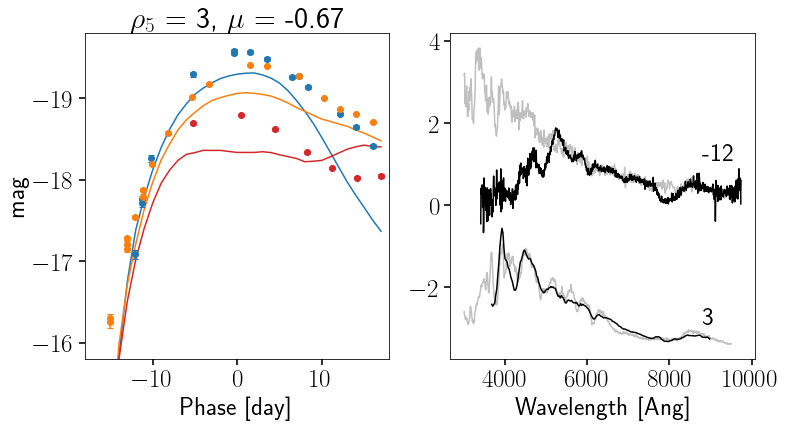

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


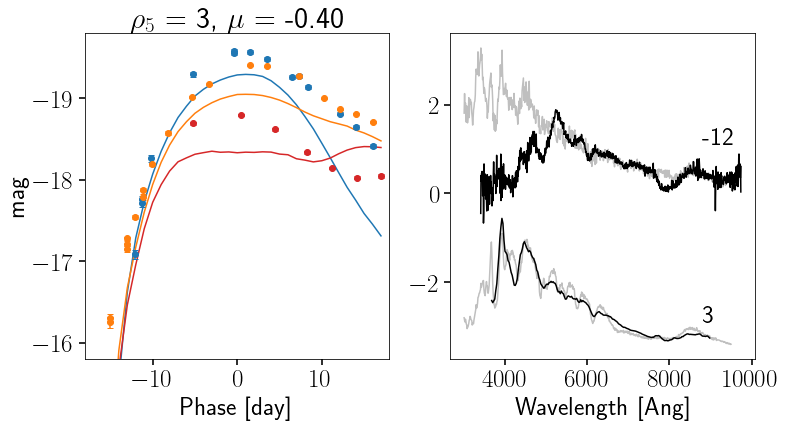

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


17.25


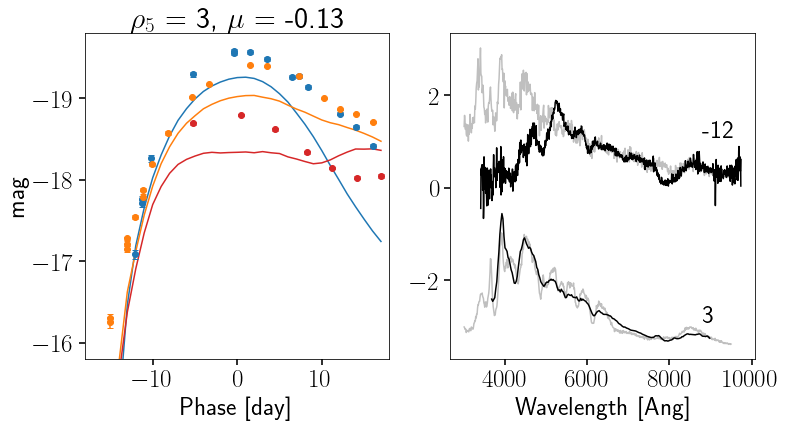

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


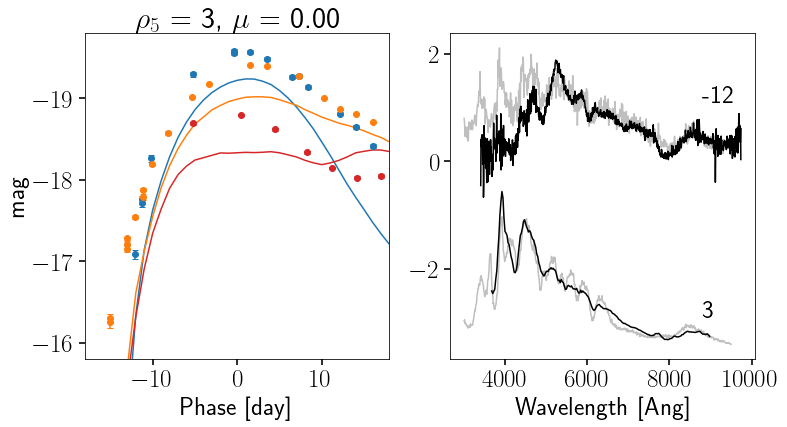

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


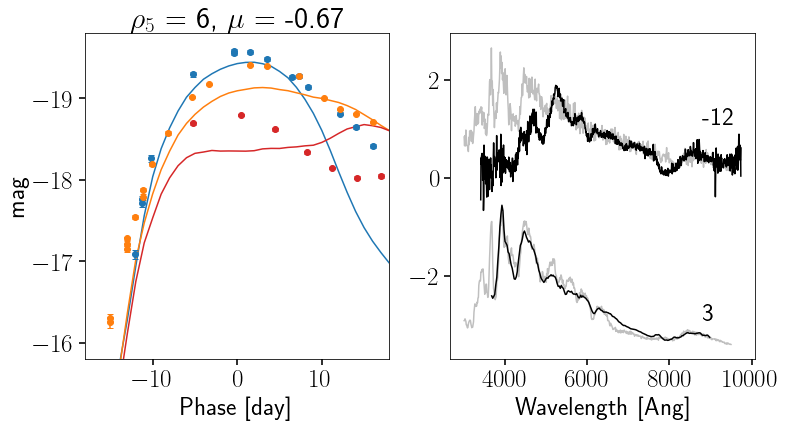

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.25


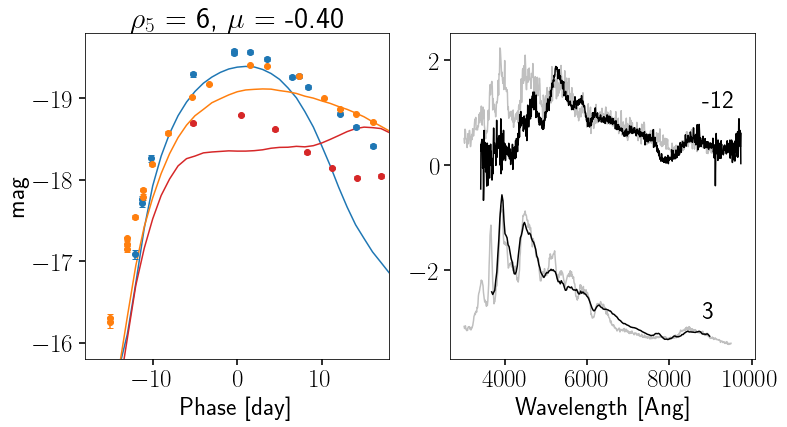

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


15.25


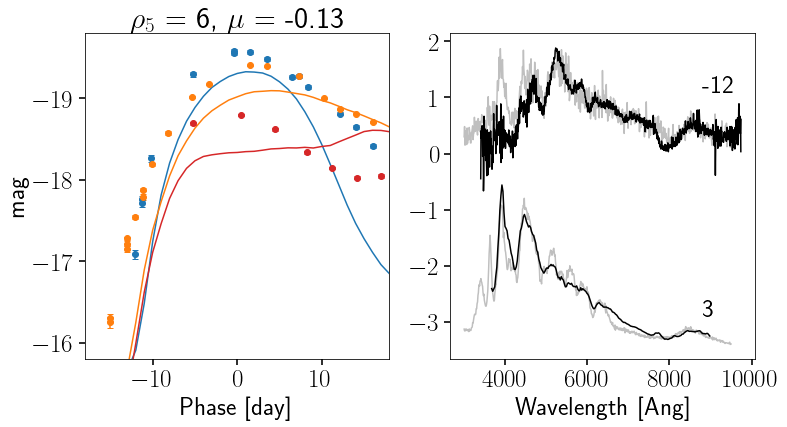

/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


15.25


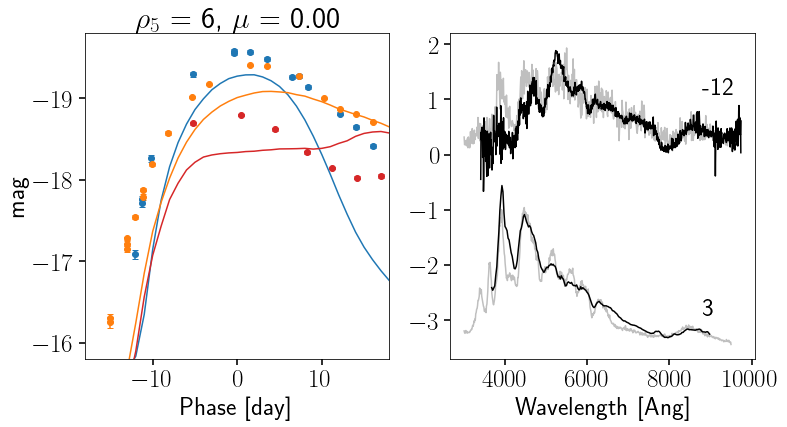

In [21]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.0_[3-9]e5.h5"))
filters = sorted(glob.glob("./filters/*P48*"))

for model in models:
    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    fit_B = np.empty_like(time[ind][::2])
    for i in [2, 4, 6, 7]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        t_max = time[ind][::2][np.argmin(fit_B)]
        print(t_max)
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color="tab:blue")
        ax[0].plot(time[ind][::2] - t_max, fit_r, color="tab:orange")
        ax[0].plot(time[ind][::2] - t_max, fit_i, color="tab:red")
        ax[0].errorbar(
            (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_g["mag"] - distmod,
            yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:blue",
        )
        ax[0].errorbar(
            (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_r["mag"] - distmod,
            yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:orange",
        )
        ax[0].errorbar(
            (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_i["mag"] - distmod,
            yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:red",
        )
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel("Phase [day]")
        ax[0].set_ylabel("mag")
        ax[0].set_title(r"$\rho_5$ = {}, $\mu$ = {:.2f}".format(rho, cos_theta[i]))

        phases = np.array([-12.1, 2.52])
        specs = [spec1, spec2]
        for k in range(2):

            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 9500)
            Flam_bin = data_binning(
                np.array(
                    [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]
                ).T,
                size=10,
            )
            ax[1].plot(
                Flam_bin[:, 0],
                Flam_bin[:, 1]
                / np.median(
                    Flam_bin[(Flam_bin[:, 0] > 5500) & (Flam_bin[:, 0] < 6500), 1]
                )
                - 3.5 * k,
                color=".5",
                alpha=0.5,
            )
            ax[1].plot(
                specs[k][:, 0] / (1 + z),
                specs[k][:, 1]
                / np.median(
                    specs[k][:, 1][
                        (specs[k][:, 0] / (1 + z) > 5500)
                        & (specs[k][:, 0] / (1 + z) < 6500)
                    ]
                )
                - 3.5 * k,
                color="k",
            )
            ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 4 * k, color="k")
        ax[1].set_xlabel("Wavelength [Ang]")
        plt.show()

In [60]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.*e5.h5"))
filters = sorted(glob.glob("./filters/P48*"))

for model in models:
    m_tot = float(model.split("/")[-1].split("_")[0])
    rho = float(model.split("_")[-1].split(".")[0][:-2])
    if ((m_tot < 1.1) and (rho < 6)) or ((m_tot == 1.1) and (rho == 2)):
        continue
    # if (m_tot != 1.0) or (rho != 6): continue
    print(m_tot, rho)

    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    fit_B_0 = np.empty_like(time[ind])
    fit_B_z0 = np.empty_like(time[ind])
    for i in [0, 2, 4, 6, 8, 10, 12, 14]:
        for k, fl in enumerate(Flam[i][ind]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
            fit_B_z0[k] = spec_to_mag(
                [wv0, fl / (E_Gal * E_Host) * (1 + z), np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
            fit_B_0[k] = spec_to_mag(
                [wv, fl / (E_Gal * E_Host), np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        np.savetxt(
            "./Shen+21_model/m_{:.1f}_dens_{}e5_mu_{:.0f}_lc.txt".format(
                m_tot, rho, cos_theta[i] * 100
            ),
            np.array([time[ind], fit_g, fit_r, fit_i, fit_B, fit_B_z0, fit_B_0]).T,
            fmt="%.2f %.3f %.3f %.3f %.3f %.3f %.3f",
            header="Time ZTFg ZTFr ZTFi B B(intrinsic) B(unreddened)",
        )
        t_max = time[ind][np.argmin(fit_B)]
        print(t_max)

        # phase_idx = np.argmin(np.abs(time - t_max))
        # idx_wv = (wv0 > 3000) & (wv0 < 10000)
        # np.savetxt(
        #     "./Shen+21_model/m_{:.1f}_dens_{}e5_mu_{:.0f}_spec.txt".format(
        #         m_tot, rho, cos_theta[i] * 100
        #     ),
        #     np.array(
        #         [
        #             wv,
        #             Flam[i][phase_idx],  # 10 pc --> D_L Mpc
        #         ]
        #     ).T[idx_wv, :],
        #     fmt="%.4f %.4e",
        #     header="time_explosion = {}\n".format(time[phase_idx]),
        # )

1.0 14.0


/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


14.75
15.75
15.75
15.25
14.75
14.25
13.75
12.75
1.0 6.0
16.75
16.75
16.25
15.25
14.75
14.25
13.75
12.75
1.1 3.0
17.25
16.25
17.25
17.75
17.25
15.25
14.75
13.75


In [25]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.*e5.h5"))
filters = sorted(glob.glob("./filters/P48*"))

for model in models:
    m_tot = float(model.split("/")[-1].split("_")[0])
    rho = float(model.split("_")[-1].split(".")[0][:-2])
    if ((m_tot < 1.1) and (rho < 6)) or ((m_tot == 1.1) and (rho == 2)):
        continue
    print(m_tot, rho)

    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 11) & (time < 23)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    fit_B_0 = np.empty_like(time[ind])
    # if m_tot == 1 and rho == '6':
    #     i_range = [2, 4, 6]
    # else:
    #     i_range = [0, 2, 4]
    i_range = [2, 7]
    for i in i_range:
        for k, fl in enumerate(Flam[i][ind]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
            fit_B_0[k] = spec_to_mag(
                [wv, fl / (E_Gal * E_Host), np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        t_max = time[ind][np.argmin(fit_B)]
        print(t_max)

        phases = [-13, -12, -11, 0, 1, 2, 3]
        for k in range(len(phases)):
            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 10000)

            np.savetxt(
                "./Shen+21_model/m_{:.1f}_dens_{}e5_mu_{:.0f}_phase_{:.0f}_spec.txt".format(
                    m_tot, rho, cos_theta[i] * 100, phases[k]
                ),
                np.array(
                    [
                        wv,
                        Flam[i][phase_idx],  # 10 pc --> D_L Mpc
                    ]
                ).T[idx_wv, :],
                fmt="%.4f %.4e",
                header="time_explosion = {}\n".format(time[phase_idx]),
            )

        phases = [-12.1, 0, 2.52]
        for k in range(len(phases)):
            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            log_Lsun = np.log10(
                trapz(
                    (Flam[i][phase_idx] / (E_Gal * E_Host))[idx_wv],
                    wv0[idx_wv],
                )
                * (4 * np.pi * (10 * u.pc).to("cm").value ** 2)
                * (1 + z)
                / 3.828e33  # Lsun in cgs
            )
            np.savetxt(
                "../TARDIS/Shen+2021/d{}e5_mu_{:.0f}_phase_{:.1f}_spec.txt".format(
                    rho, cos_theta[i] * 100, phases[k]
                ),
                np.array(
                    [
                        wv0,
                        Flam[i][phase_idx]
                        / (E_Gal * E_Host)
                        * (1 + z)
                        * (10e-6 / 114.48) ** 2,  # 10 pc --> D_L Mpc
                    ]
                ).T[idx_wv, :],
                fmt="%.4f %.4e",
                header="time_explosion = {}\n".format(time[phase_idx])
                + "log_Lsun = {:.2f}".format(log_Lsun),
            )

1.0 14.0
15.75
14.75
1.0 6.0
16.75
14.75
1.1 3.0
16.25
15.75


## Modeling the silicon features

In [11]:
sys.path.append('../spectroscopy')

from absorption_line_vel import SpectrumSN_Lines

# read spec data
z = 0.02736 #redshift
synth_spec = [f for f in sorted(glob.glob('./Shen+21_model/*mu*spec*')) if not 'phase' in f]
synth_lc = sorted(glob.glob('./Shen+21_model/*mu*lc*'))

def lambda_rf(lambda_0, vel):
    c = 2.99792458e5
    beta = vel / c
    lambda_rf = np.sqrt((1 + beta) / (1 - beta)) * lambda_0
    return lambda_rf

In [12]:
synth_spec

['./Shen+21_model/m_1.0_dens_14e5_mu_-13_spec.txt',
 './Shen+21_model/m_1.0_dens_14e5_mu_-40_spec.txt',
 './Shen+21_model/m_1.0_dens_14e5_mu_-67_spec.txt',
 './Shen+21_model/m_1.0_dens_14e5_mu_-93_spec.txt',
 './Shen+21_model/m_1.0_dens_14e5_mu_13_spec.txt',
 './Shen+21_model/m_1.0_dens_14e5_mu_40_spec.txt',
 './Shen+21_model/m_1.0_dens_14e5_mu_67_spec.txt',
 './Shen+21_model/m_1.0_dens_14e5_mu_93_spec.txt',
 './Shen+21_model/m_1.0_dens_6e5_mu_-13_spec.txt',
 './Shen+21_model/m_1.0_dens_6e5_mu_-40_spec.txt',
 './Shen+21_model/m_1.0_dens_6e5_mu_-67_spec.txt',
 './Shen+21_model/m_1.0_dens_6e5_mu_-93_spec.txt',
 './Shen+21_model/m_1.0_dens_6e5_mu_13_spec.txt',
 './Shen+21_model/m_1.0_dens_6e5_mu_40_spec.txt',
 './Shen+21_model/m_1.0_dens_6e5_mu_67_spec.txt',
 './Shen+21_model/m_1.0_dens_6e5_mu_93_spec.txt',
 './Shen+21_model/m_1.1_dens_3e5_mu_-13_spec.txt',
 './Shen+21_model/m_1.1_dens_3e5_mu_-40_spec.txt',
 './Shen+21_model/m_1.1_dens_3e5_mu_-67_spec.txt',
 './Shen+21_model/m_1.1_dens_3e

1.0 1400000.0 -13.0
assign manual snr...
LS estimation:
Velocity 1: -10606 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10715.349  184.620 -10887.498 -10526.849      2.727    1.929   
v_sig[0]    2553.352  193.631   2350.005   2731.480      3.564    2.521   
A[0]        -803.624   64.512   -863.639   -736.268      1.244    0.881   
sigma_0        0.071    0.004      0.067      0.075      0.000    0.000   
EW_0          36.407    2.732     33.576     39.020      0.052    0.037   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4579.739  3203.696  1.002  
v_sig[0]   2935.248  2686.207  1.000  
A[0]       2685.459  2768.759  1.002  
sigma_0    4390.144  3057.776  1.000  
EW_0       2727.265  2830.362  1.001  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


assign manual snr...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11083.150  276.976 -11350.471 -10817.272      4.210    2.977   
v_sig[0]    2366.198  254.084   2215.843   2759.166      4.614    3.263   
A[0]        -504.807   74.103   -574.599   -424.417      1.431    1.012   
sigma_0        0.092    0.005      0.087      0.097      0.000    0.000   
EW_0          16.144    2.275     13.606     18.211      0.044    0.031   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4337.139  2803.565  1.001  
v_sig[0]   2817.130  2386.858  1.001  
A[0]       2641.893  2687.737  1.000  
sigma_0    4107.716  2958.922  1.002  
EW_0       2666.230  2744.142  1.000  


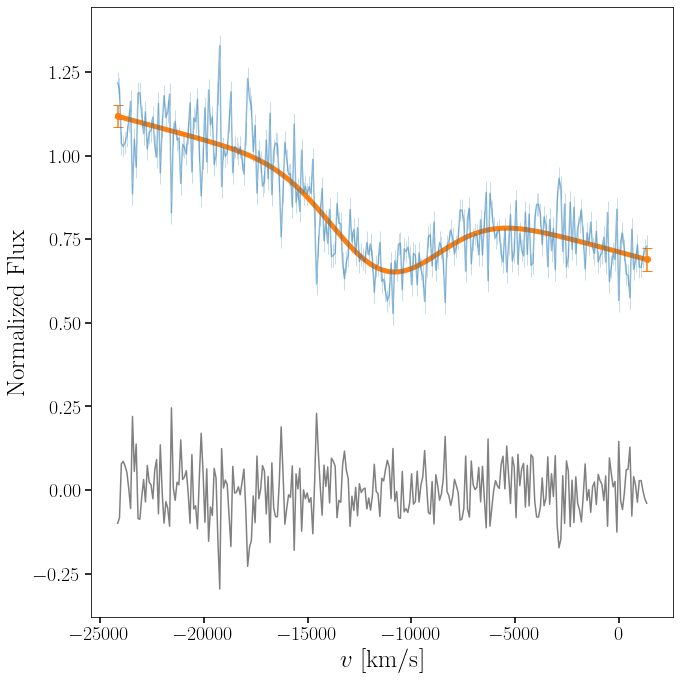

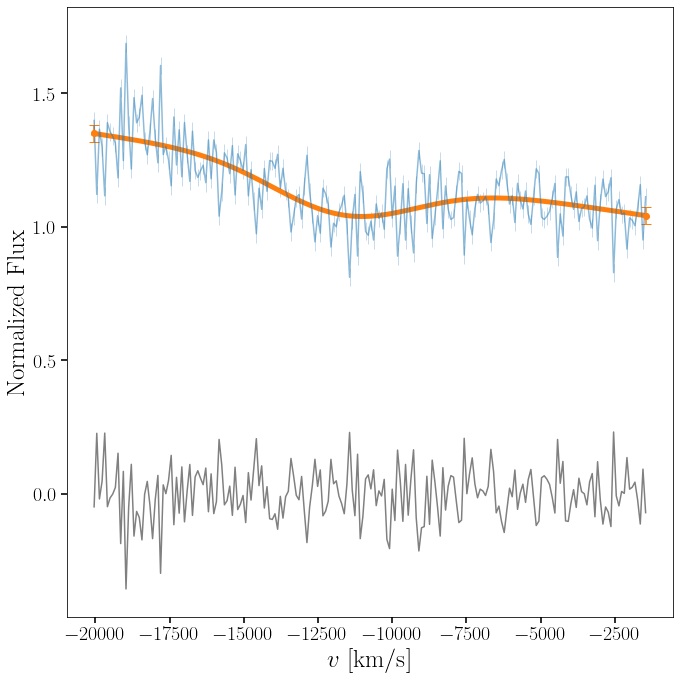

1.0 1400000.0 -40.0
assign manual snr...
LS estimation:
Velocity 1: -10586 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10729.479  162.466 -10882.246 -10564.702      2.510    1.777   
v_sig[0]    2568.968  183.301   2393.153   2748.794      3.237    2.289   
A[0]        -743.374   54.897   -792.570   -686.211      1.052    0.744   
sigma_0        0.059    0.003      0.055      0.062      0.000    0.000   
EW_0          35.150    2.432     32.413     37.138      0.046    0.032   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4176.932  3035.927    1.0  
v_sig[0]   3198.875  2565.247    1.0  
A[0]       2742.381  2671.735    1.0  
sigma_0    4366.303  2855.819    1.0  
EW_0       2830.402  2770.657    1.0  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.7076, but should be close to 0.8. Try to increase the number of tuning steps.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11142.110  354.692 -11518.221 -10812.164      5.938    4.199   
v_sig[0]    2615.032  165.674   2572.633   2806.349      3.389    2.397   
A[0]        -388.310   59.774   -447.787   -329.848      1.131    0.800   
sigma_0        0.073    0.004      0.069      0.077      0.000    0.000   
EW_0          13.067    1.946     11.306     15.163      0.037    0.026   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3581.358  2745.553  1.001  
v_sig[0]   2622.388  2368.101  1.000  
A[0]       2789.516  2173.911  1.000  
sigma_0    3639.362  2440.949  1.001  
EW_0       2807.820  2199.150  1.000  


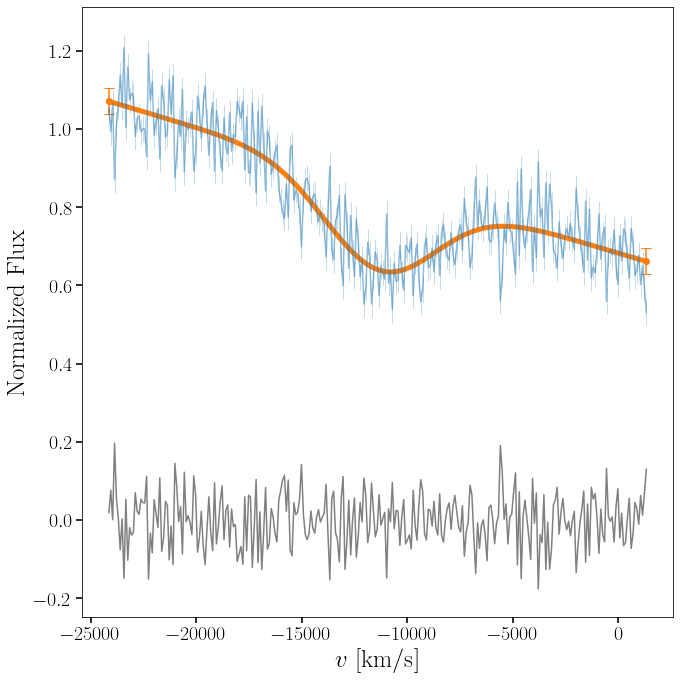

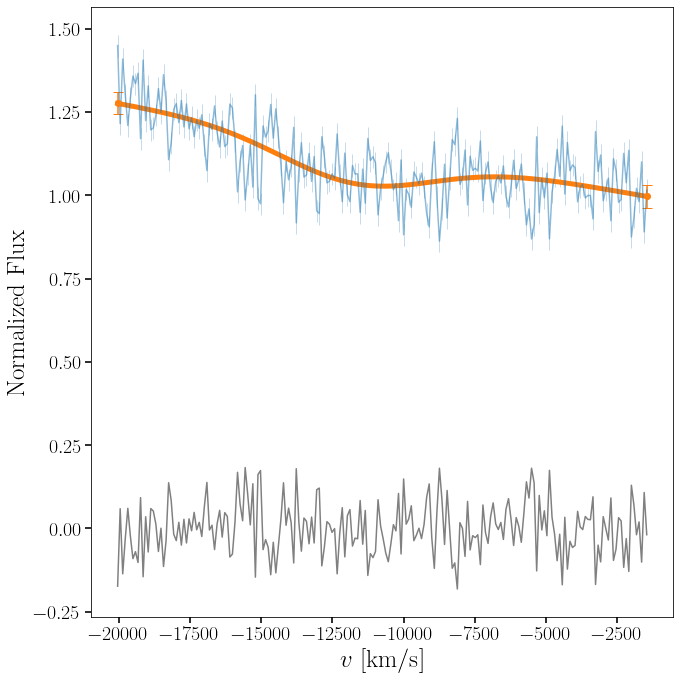

1.0 1400000.0 -67.0
assign manual snr...
LS estimation:
Velocity 1: -10674 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10747.477  185.021 -10918.681 -10550.912      2.928    2.071   
v_sig[0]    2506.257  221.935   2265.636   2694.126      3.963    2.802   
A[0]        -636.375   55.569   -690.682   -582.031      1.087    0.769   
sigma_0        0.058    0.003      0.055      0.061      0.000    0.000   
EW_0          30.399    2.504     27.847     32.742      0.049    0.035   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3987.554  2823.435  1.003  
v_sig[0]   3113.544  2827.645  1.001  
A[0]       2602.636  2562.559  1.001  
sigma_0    4485.923  2938.579  1.001  
EW_0       2628.668  2614.875  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11869.256  352.200 -12240.707 -11539.262      5.987    4.234   
v_sig[0]    2522.767  180.755   2480.982   2733.111      3.258    2.304   
A[0]        -401.690   65.988   -465.507   -334.038      1.347    0.953   
sigma_0        0.079    0.005      0.074      0.083      0.000    0.000   
EW_0          13.426    2.130     11.202     15.444      0.043    0.031   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3467.863  3192.694  1.001  
v_sig[0]   3076.431  2379.855  1.000  
A[0]       2384.464  2591.311  1.001  
sigma_0    4669.920  2908.362  1.000  
EW_0       2393.851  2557.718  1.001  


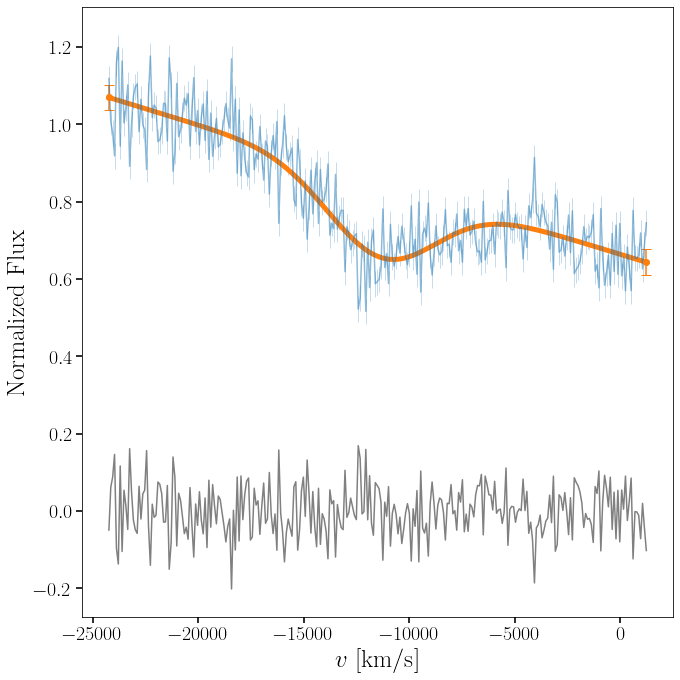

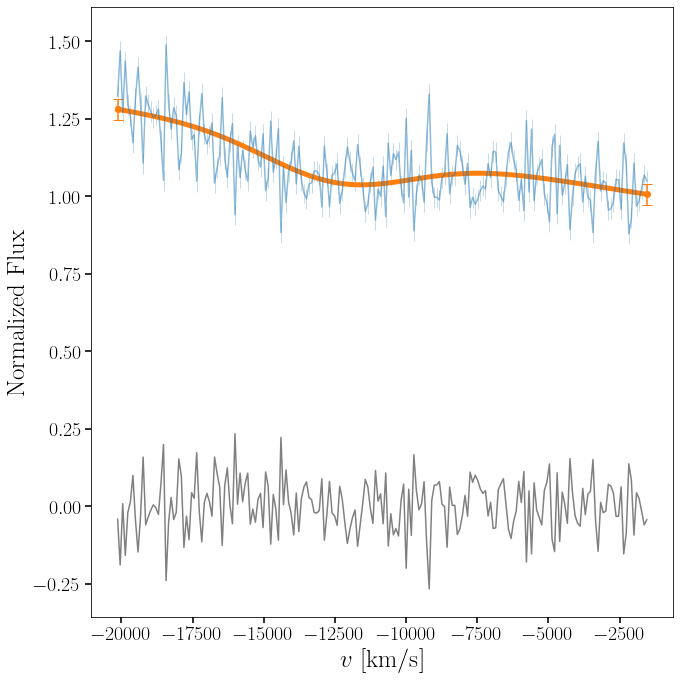

1.0 1400000.0 -93.0
assign manual snr...
LS estimation:
Velocity 1: -11210 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11182.240  256.988 -11449.635 -10949.432      4.201    2.971   
v_sig[0]    2525.522  302.404   2215.129   2804.207      5.711    4.038   
A[0]        -505.422   58.893   -553.889   -439.531      1.163    0.822   
sigma_0        0.063    0.003      0.060      0.067      0.000    0.000   
EW_0          24.663    2.742     21.815     27.130      0.054    0.038   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3763.110  2922.544  1.000  
v_sig[0]   2799.347  2593.110  1.001  
A[0]       2547.368  2459.844  1.001  
sigma_0    4159.010  2817.097  1.001  
EW_0       2568.093  2501.081  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8858, but should be close to 0.8. Try to increase the number of tuning steps.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11335.443  546.907 -11845.524 -10786.026     10.921    7.854   
v_sig[0]    2300.078  282.304   2134.072   2746.457      4.580    3.264   
A[0]         -39.624   33.625    -47.317     -0.019      0.801    0.589   
sigma_0        0.083    0.005      0.077      0.086      0.000    0.000   
EW_0           1.377    1.162      0.000      1.644      0.028    0.020   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2619.946  1559.261  1.001  
v_sig[0]   3542.388  2434.950  1.002  
A[0]       1724.764  1786.954  1.000  
sigma_0    4180.767  2688.883  1.003  
EW_0       1729.180  1763.165  1.000  


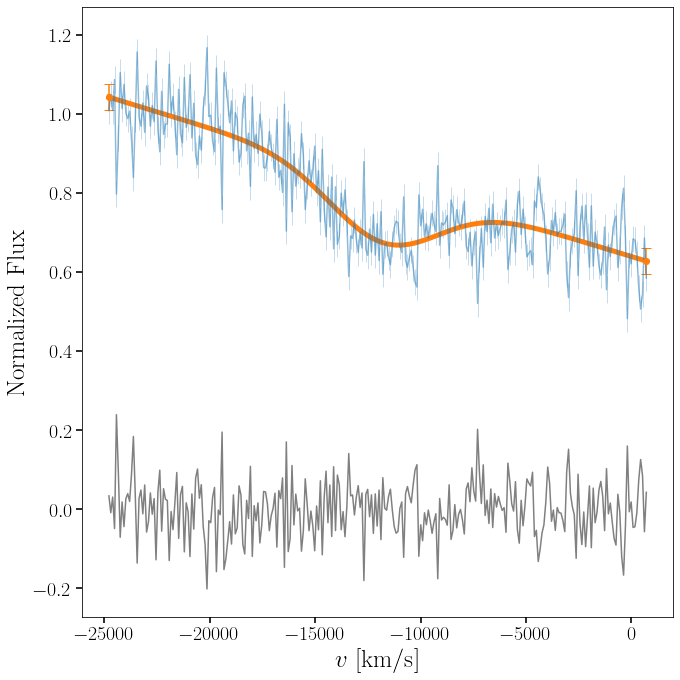

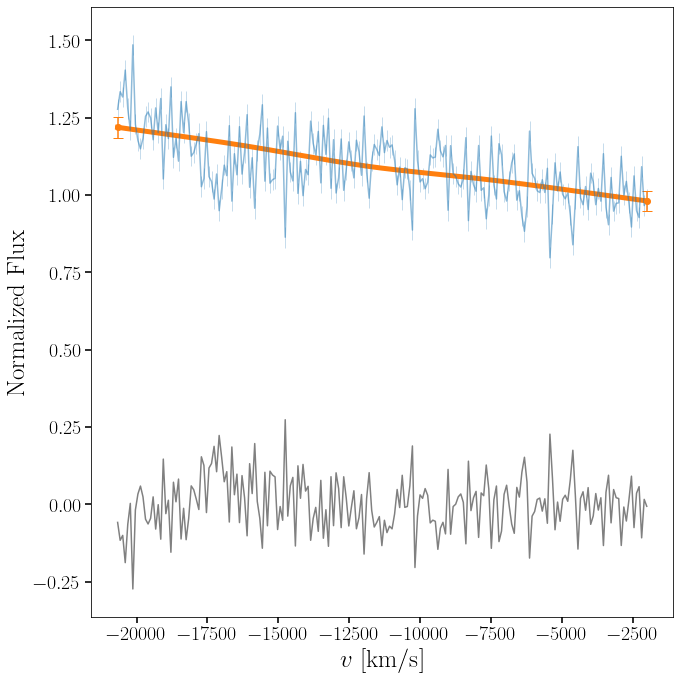

1.0 1400000.0 13.0
assign manual snr...
LS estimation:
Velocity 1: -11228 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11444.728  172.337 -11618.585 -11282.642      2.566    1.817   
v_sig[0]    2841.560  196.530   2633.223   3023.172      3.458    2.449   
A[0]        -964.980   69.571  -1025.878   -890.289      1.277    0.905   
sigma_0        0.071    0.004      0.067      0.075      0.000    0.000   
EW_0          40.431    2.705     37.842     43.132      0.049    0.035   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4515.104  3134.005  1.000  
v_sig[0]   3227.698  3033.365  1.000  
A[0]       2989.609  2941.707  1.001  
sigma_0    4314.185  2531.660  1.000  
EW_0       3031.454  3096.007  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10648.039  214.687 -10851.068 -10435.753      3.506    2.483   
v_sig[0]    2376.414  229.618   2065.715   2510.906      4.531    3.244   
A[0]        -652.295   75.017   -716.917   -570.701      1.510    1.078   
sigma_0        0.088    0.005      0.083      0.093      0.000    0.000   
EW_0          19.452    2.125     17.119     21.270      0.042    0.030   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3796.337  2751.388  1.001  
v_sig[0]   2609.056  2141.300  1.001  
A[0]       2516.016  2310.217  1.001  
sigma_0    4285.008  2762.305  1.002  
EW_0       2541.582  2454.985  1.001  


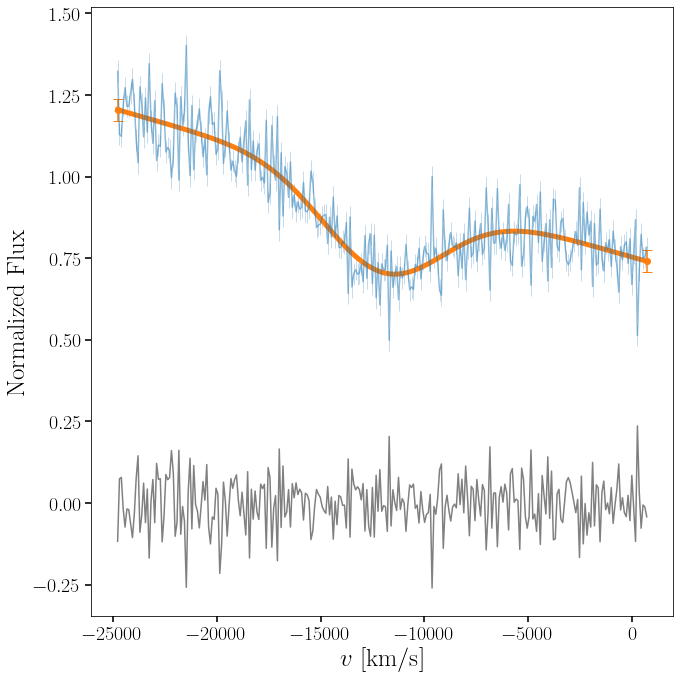

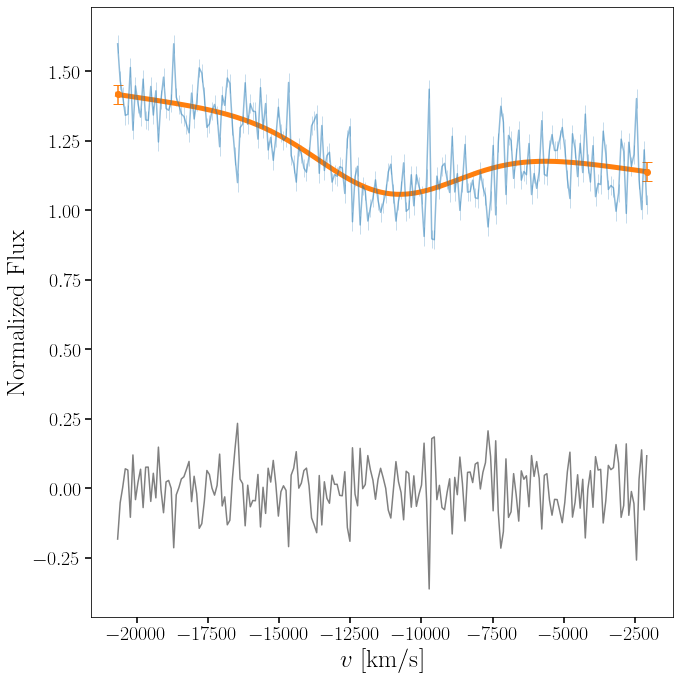

1.0 1400000.0 40.0
assign manual snr...
LS estimation:
Velocity 1: -11136 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11228.190  164.695 -11389.890 -11065.632      2.461    1.740   
v_sig[0]    2817.982  195.701   2609.807   2990.619      3.330    2.355   
A[0]       -1102.209   79.354  -1180.155  -1025.038      1.436    1.016   
sigma_0        0.081    0.004      0.077      0.085      0.000    0.000   
EW_0          42.648    2.842     39.944     45.498      0.051    0.036   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4479.532  3057.628  1.000  
v_sig[0]   3445.943  2963.285  1.001  
A[0]       3058.603  2664.115  1.002  
sigma_0    4910.515  2657.731  1.000  
EW_0       3119.474  2762.876  1.002  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11583.526  224.088 -11793.483 -11350.116      3.306    2.339   
v_sig[0]    2159.274  151.325   1988.284   2191.947      2.519    1.788   
A[0]        -612.571   67.842   -675.616   -543.790      1.159    0.824   
sigma_0        0.109    0.006      0.102      0.114      0.000    0.000   
EW_0          17.068    1.810     15.236     18.740      0.031    0.022   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4580.339  2947.538  1.001  
v_sig[0]   3254.477  2381.435  1.000  
A[0]       3459.386  2717.220  1.002  
sigma_0    4663.168  2860.550  1.001  
EW_0       3520.071  2716.234  1.002  


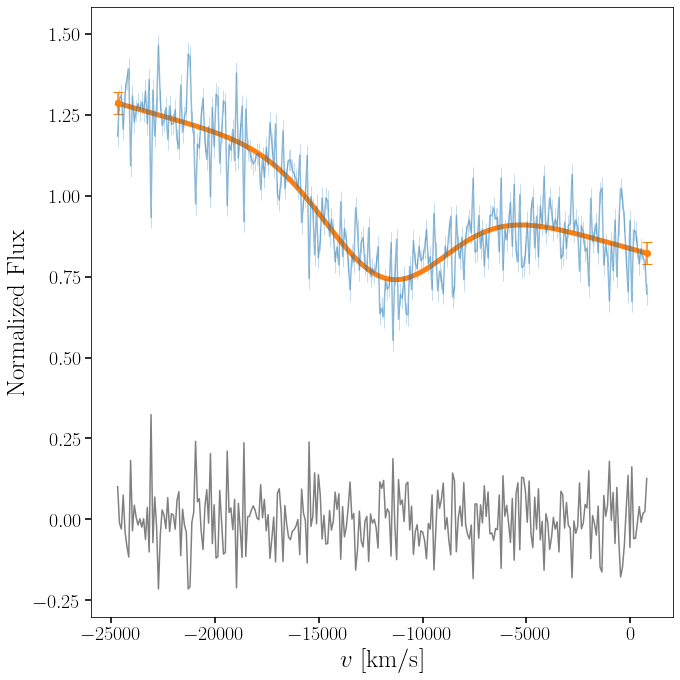

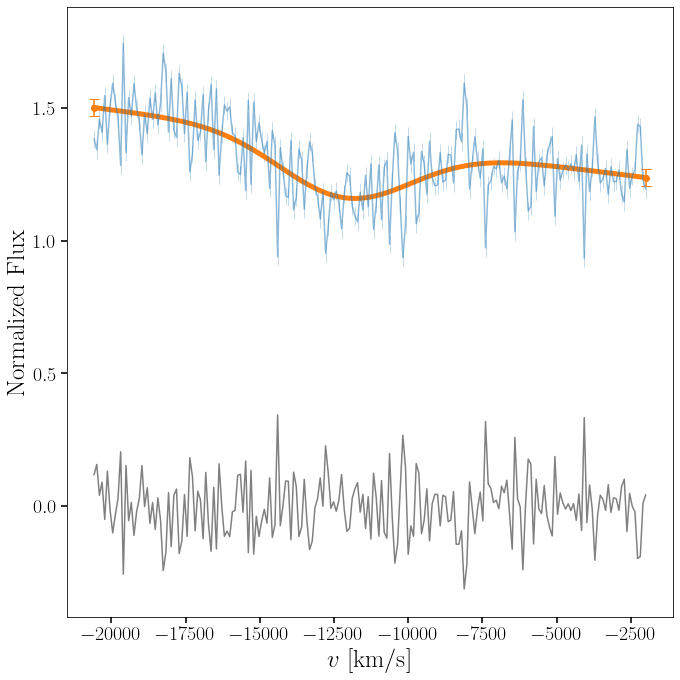

1.0 1400000.0 67.0
assign manual snr...
LS estimation:
Velocity 1: -12218 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 12 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12287.753  180.881 -12488.233 -12126.310      2.960    2.093   
v_sig[0]    2900.875  200.119   2706.751   3099.254      3.766    2.663   
A[0]       -1284.924   95.784  -1370.431  -1185.893      1.855    1.315   
sigma_0        0.101    0.005      0.096      0.105      0.000    0.000   
EW_0          42.463    2.928     39.413     45.070      0.056    0.040   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3720.750  3028.494  1.001  
v_sig[0]   2820.838  2920.842  1.003  
A[0]       2681.937  2614.017  1.003  
sigma_0    3862.116  2568.456  1.001  
EW_0       2709.487  2785.201  1.003  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12024.338  312.539 -12350.830 -11738.774      4.972    3.516   
v_sig[0]    2403.640  269.306   2046.928   2496.554      4.301    3.092   
A[0]        -506.010   84.209   -584.414   -422.684      1.411    1.018   
sigma_0        0.131    0.007      0.124      0.137      0.000    0.000   
EW_0          12.313    1.993     10.267     14.103      0.033    0.024   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3957.399  2712.214  1.001  
v_sig[0]   3792.408  2301.500  1.002  
A[0]       3601.800  2941.757  1.001  
sigma_0    4747.227  2849.638  1.002  
EW_0       3640.720  2919.554  1.001  


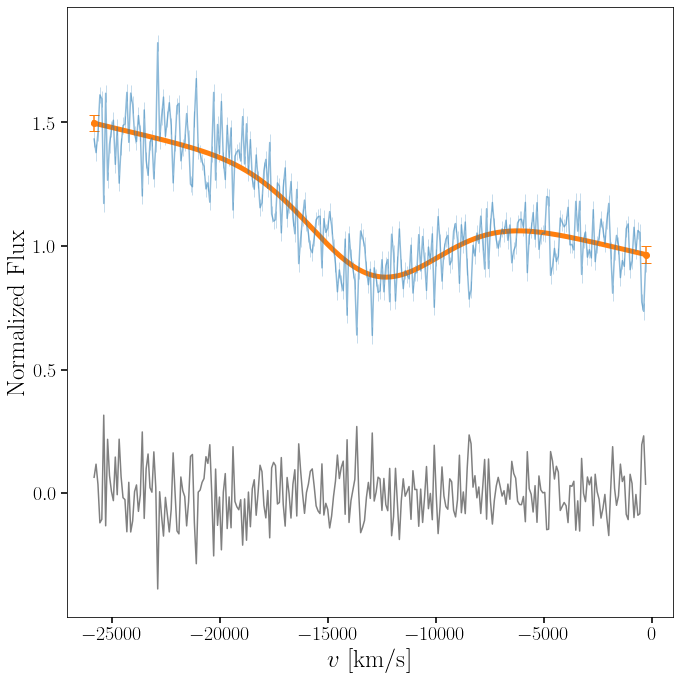

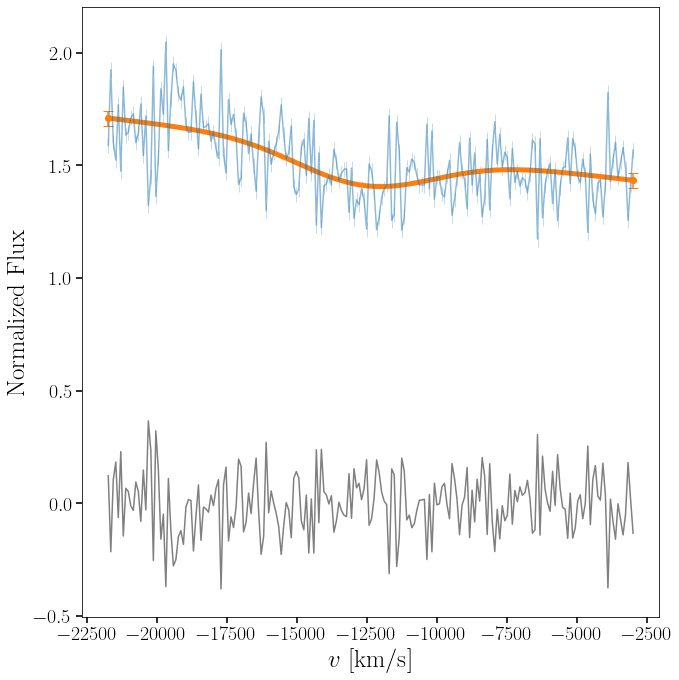

1.0 1400000.0 93.0
assign manual snr...
LS estimation:
Velocity 1: -13189 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -13162.959  223.719 -13397.743 -12959.526      3.388    2.396   
v_sig[0]    3500.171  235.802   3246.709   3705.047      4.557    3.236   
A[0]       -2080.955  161.896  -2218.461  -1899.674      3.240    2.294   
sigma_0        0.157    0.007      0.150      0.164      0.000    0.000   
EW_0          53.221    3.791     49.416     56.918      0.075    0.053   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4337.060  3263.283  1.001  
v_sig[0]   2698.596  2761.992  1.002  
A[0]       2499.137  2408.411  1.002  
sigma_0    3555.019  2468.310  1.000  
EW_0       2563.123  2560.065  1.002  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 12 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12859.596  351.133 -13199.320 -12516.443      5.514    3.902   
v_sig[0]    2836.235  287.064   2469.985   2921.245      4.715    3.384   
A[0]        -723.028  120.121   -841.774   -609.103      2.070    1.489   
sigma_0        0.170    0.009      0.160      0.178      0.000    0.000   
EW_0          13.754    2.216     11.717     16.020      0.038    0.027   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4061.661  3018.241  1.001  
v_sig[0]   3755.245  2618.396  1.002  
A[0]       3424.851  2708.999  1.000  
sigma_0    4567.857  2671.595  1.001  
EW_0       3455.601  2728.344  1.000  


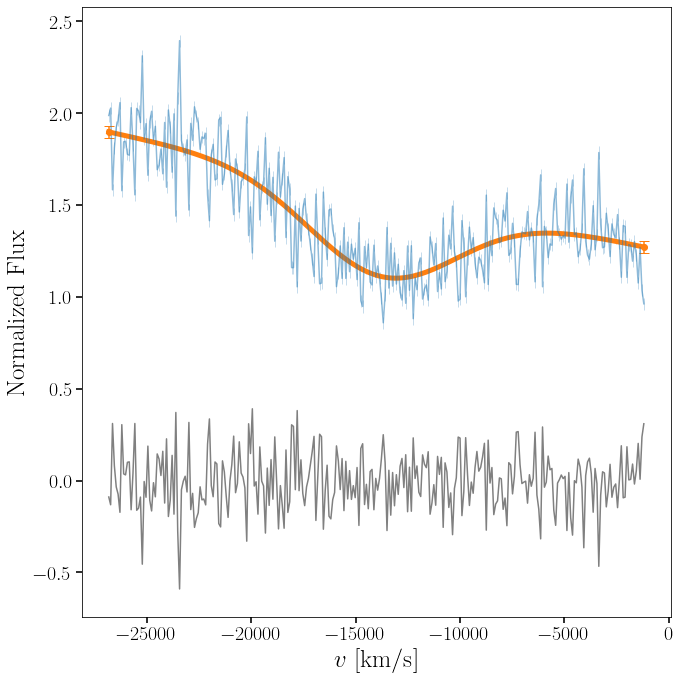

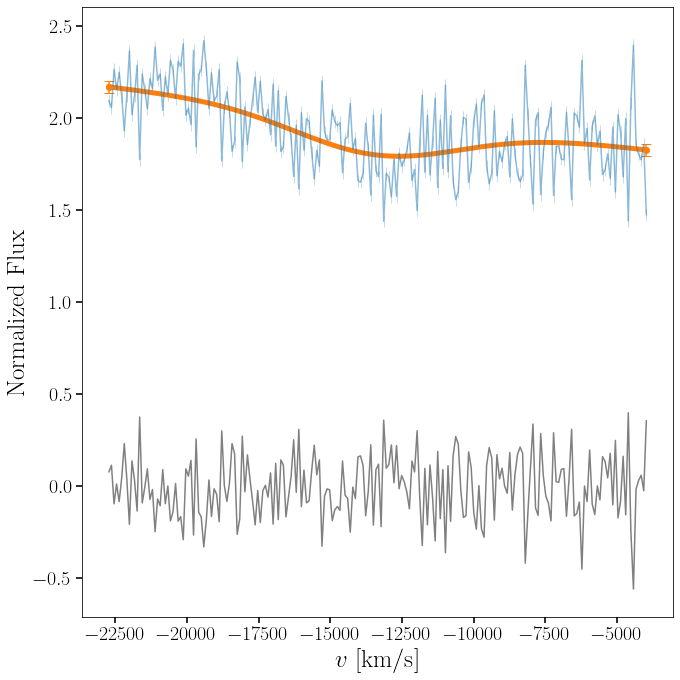

1.0 600000.0 -13.0
assign manual snr...
LS estimation:
Velocity 1: -11002 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11082.056  122.728 -11208.209 -10967.667      1.897    1.341   
v_sig[0]    2771.176  143.923   2619.843   2902.554      2.719    1.923   
A[0]       -1292.911   70.698  -1361.558  -1223.819      1.438    1.017   
sigma_0        0.071    0.004      0.067      0.074      0.000    0.000   
EW_0          55.521    2.734     52.961     58.279      0.055    0.039   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4196.235  3224.057  1.000  
v_sig[0]   2804.695  2711.723  1.001  
A[0]       2413.049  2422.727  1.001  
sigma_0    4554.493  2963.387  1.000  
EW_0       2478.287  2626.670  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10974.618  211.374 -11182.038 -10769.765      3.267    2.311   
v_sig[0]    2390.741  230.836   2114.621   2587.322      4.752    3.372   
A[0]        -695.135   78.414   -761.275   -605.688      1.706    1.219   
sigma_0        0.086    0.005      0.081      0.090      0.000    0.000   
EW_0          21.587    2.302     19.200     23.785      0.050    0.035   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4196.662  3284.921  1.001  
v_sig[0]   2288.554  2444.259  1.002  
A[0]       2151.873  2690.058  1.001  
sigma_0    4235.740  2878.240  1.000  
EW_0       2178.994  2688.093  1.000  


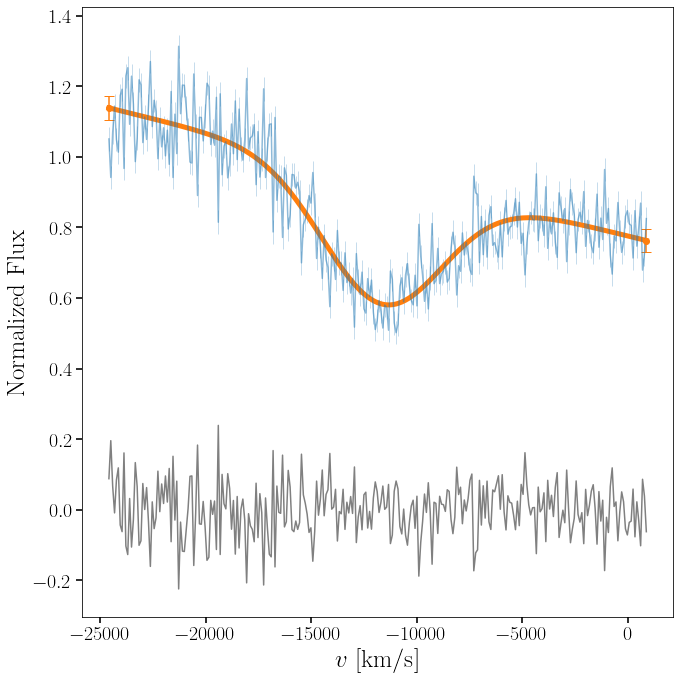

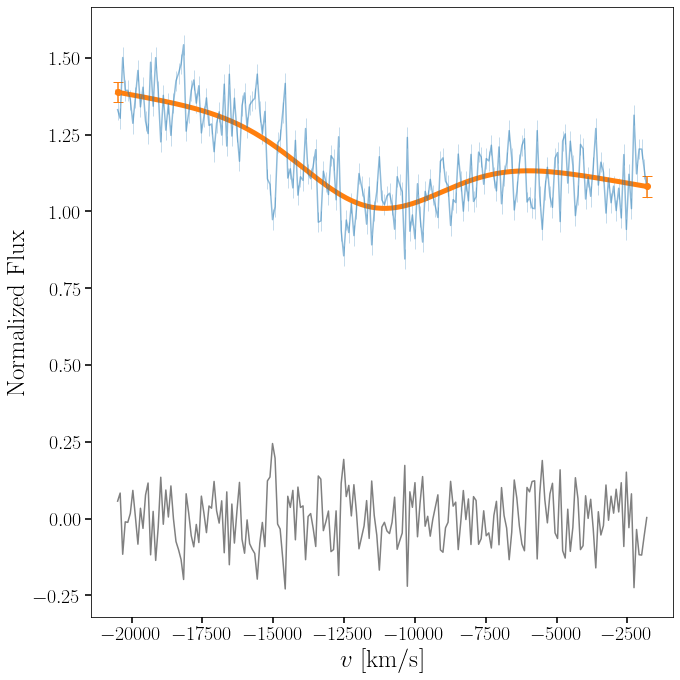

1.0 600000.0 -40.0
assign manual snr...
LS estimation:
Velocity 1: -10835 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10911.555   91.092 -10995.630 -10814.912      1.457    1.031   
v_sig[0]    2549.803  105.085   2442.379   2648.827      1.827    1.293   
A[0]       -1199.786   51.352  -1255.776  -1154.383      0.919    0.651   
sigma_0        0.053    0.003      0.050      0.056      0.000    0.000   
EW_0          53.209    2.062     51.329     55.367      0.037    0.026   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3906.370  2740.996  1.001  
v_sig[0]   3317.668  3145.595  1.000  
A[0]       3125.602  2975.996  1.000  
sigma_0    4178.129  2508.696  1.000  
EW_0       3177.255  2869.024  1.000  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11162.537  149.643 -11290.781 -10996.304      2.376    1.680   
v_sig[0]    1990.844  131.677   1803.170   2036.334      2.379    1.682   
A[0]        -629.939   49.976   -678.639   -580.697      0.935    0.670   
sigma_0        0.073    0.004      0.068      0.076      0.000    0.000   
EW_0          20.176    1.520     18.592     21.566      0.028    0.020   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3970.666  3248.946  1.000  
v_sig[0]   2781.313  2165.554  1.000  
A[0]       2935.204  2423.161  1.002  
sigma_0    4470.453  3148.636  1.002  
EW_0       2970.462  2404.571  1.002  


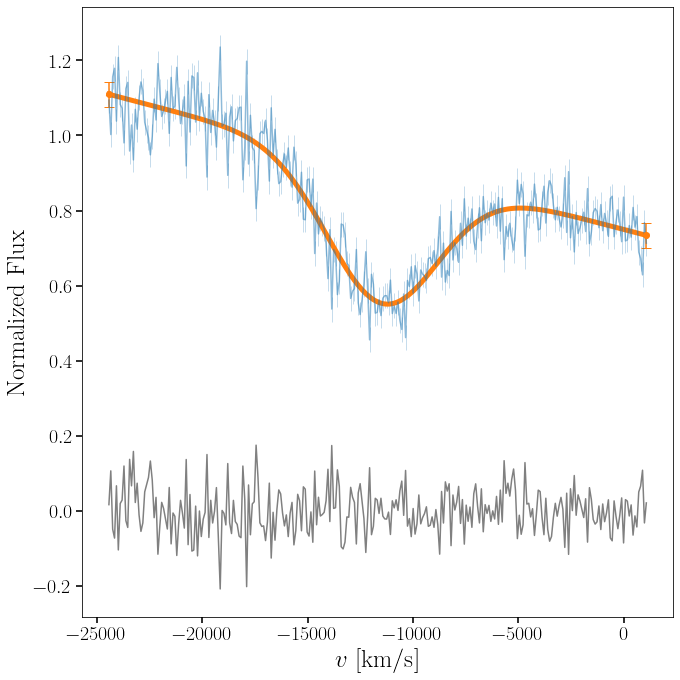

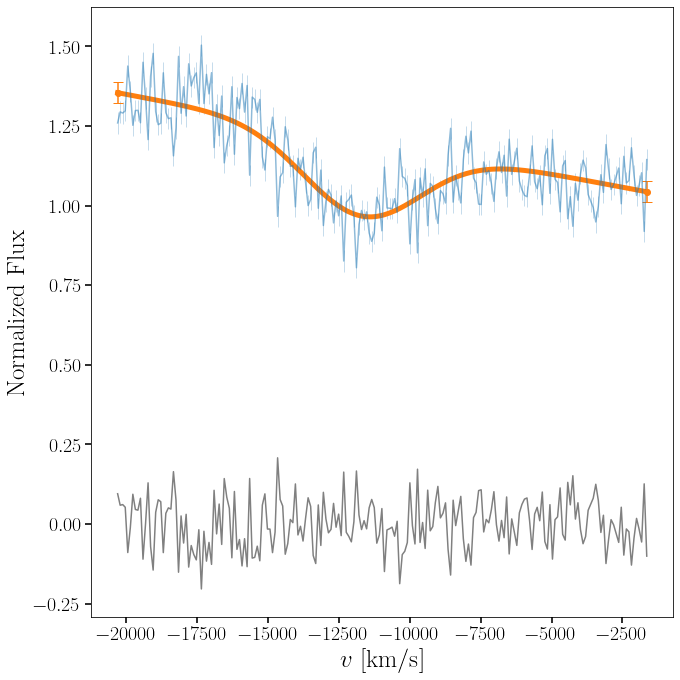

1.0 600000.0 -67.0
assign manual snr...
LS estimation:
Velocity 1: -10600 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -10765.653  121.037 -10885.348 -10648.470      1.966    1.390   
v_sig[0]    2754.864  141.022   2610.441   2886.544      2.670    1.892   
A[0]       -1095.379   58.675  -1155.662  -1037.751      1.194    0.847   
sigma_0        0.057    0.003      0.053      0.060      0.000    0.000   
EW_0          50.048    2.434     47.652     52.546      0.049    0.035   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3838.674  2928.950  1.002  
v_sig[0]   2806.014  2926.519  1.001  
A[0]       2436.154  2733.875  1.000  
sigma_0    4536.140  2829.557  1.001  
EW_0       2479.637  2856.952  1.000  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11167.080  199.143 -11398.014 -10996.225      3.242    2.292   
v_sig[0]    2653.135  208.689   2490.572   2919.049      4.874    3.457   
A[0]        -781.880   79.960   -870.322   -706.318      1.848    1.307   
sigma_0        0.074    0.005      0.069      0.078      0.000    0.000   
EW_0          25.193    2.409     22.878     27.793      0.055    0.039   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3789.773  2793.689  1.000  
v_sig[0]   1769.785  2117.390  1.001  
A[0]       1866.202  2397.546  1.002  
sigma_0    3609.989  2853.357  1.002  
EW_0       1883.532  2438.875  1.002  


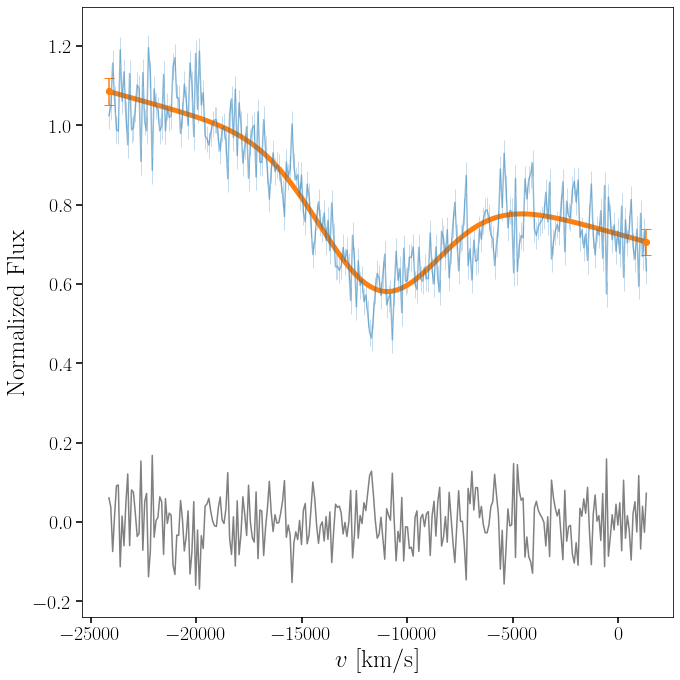

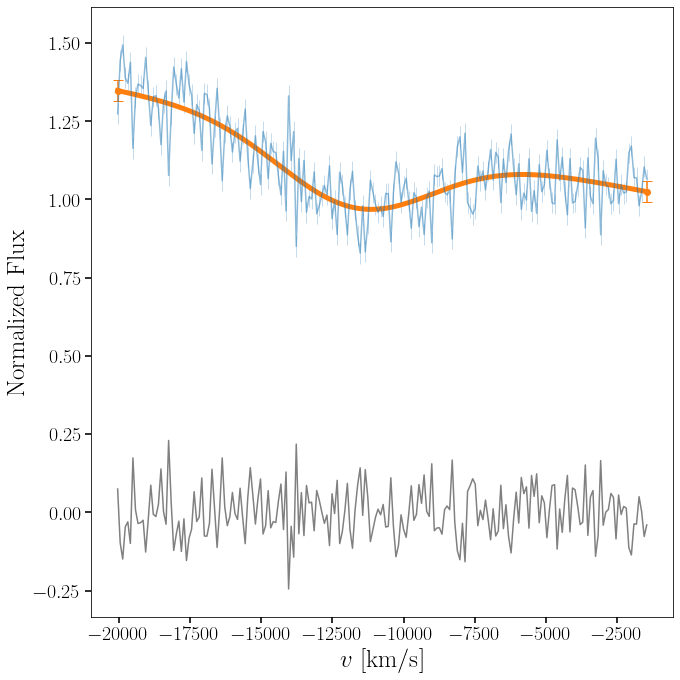

1.0 600000.0 -93.0
assign manual snr...
LS estimation:
Velocity 1: -11038 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11104.509  131.607 -11254.242 -10989.093      2.045    1.446   
v_sig[0]    2928.559  161.249   2765.775   3084.944      3.114    2.205   
A[0]        -962.298   54.373  -1009.851   -902.089      1.112    0.787   
sigma_0        0.045    0.003      0.042      0.048      0.000    0.000   
EW_0          47.254    2.444     44.704     49.519      0.049    0.035   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4149.955  2945.931  1.000  
v_sig[0]   2686.000  2927.198  1.000  
A[0]       2392.037  2381.109  1.000  
sigma_0    4068.743  2884.450  1.006  
EW_0       2442.608  2350.820  1.000  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11937.168  268.973 -12248.793 -11716.915      4.589    3.245   
v_sig[0]    2888.622  213.818   2800.914   3200.110      4.454    3.150   
A[0]        -601.686   71.758   -671.459   -527.223      1.564    1.106   
sigma_0        0.066    0.004      0.062      0.070      0.000    0.000   
EW_0          20.861    2.355     18.474     23.184      0.051    0.036   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3478.737  2828.977  1.001  
v_sig[0]   2245.917  2253.397  1.001  
A[0]       2100.117  2114.771  1.001  
sigma_0    3168.855  2551.180  1.000  
EW_0       2129.644  2250.173  1.001  


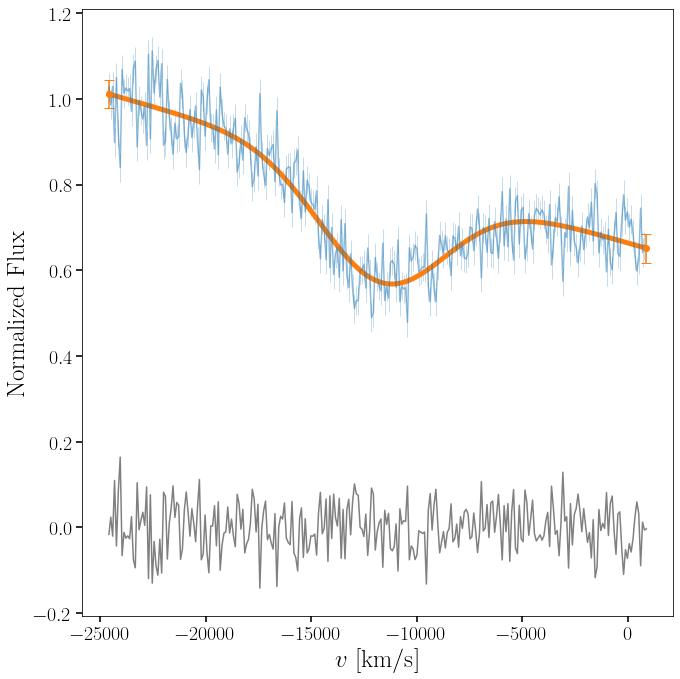

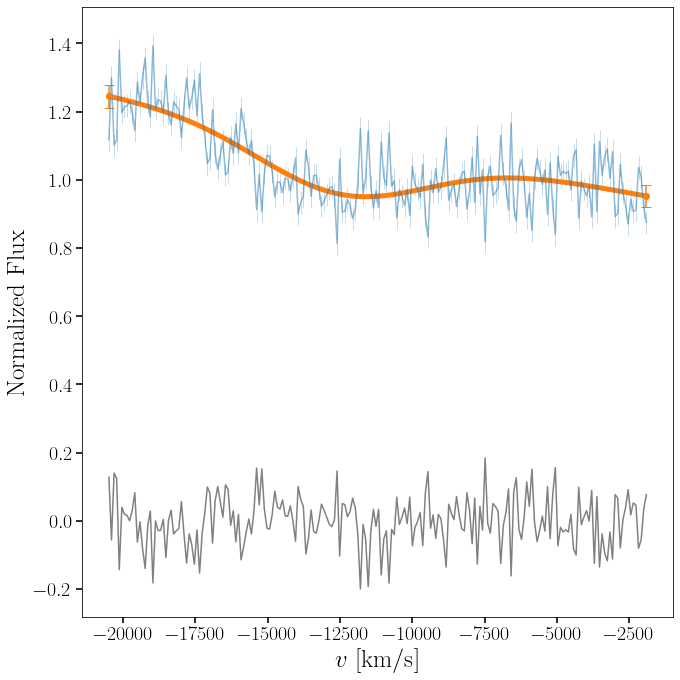

1.0 600000.0 13.0
assign manual snr...
LS estimation:
Velocity 1: -11352 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11485.306  116.080 -11600.411 -11369.540      1.812    1.282   
v_sig[0]    2952.998  133.047   2815.073   3075.712      2.562    1.812   
A[0]       -1634.941   80.522  -1710.963  -1549.624      1.645    1.164   
sigma_0        0.078    0.004      0.074      0.082      0.000    0.000   
EW_0          62.706    2.754     59.905     65.441      0.055    0.039   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4130.706  2665.881  1.003  
v_sig[0]   2699.299  2940.135  1.000  
A[0]       2397.298  2537.281  1.001  
sigma_0    4627.316  2646.066  1.002  
EW_0       2470.284  2691.163  1.000  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11437.627  184.877 -11626.420 -11259.420      2.930    2.072   
v_sig[0]    2371.241  189.374   2099.120   2451.987      3.557    2.516   
A[0]        -893.146   85.872   -967.975   -806.935      1.677    1.204   
sigma_0        0.106    0.006      0.101      0.112      0.000    0.000   
EW_0          24.606    2.221     22.430     26.635      0.043    0.031   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3975.475  2908.288  1.001  
v_sig[0]   2657.450  2007.075  1.000  
A[0]       2710.902  2342.431  1.001  
sigma_0    4535.270  3050.622  1.001  
EW_0       2752.654  2465.578  1.001  


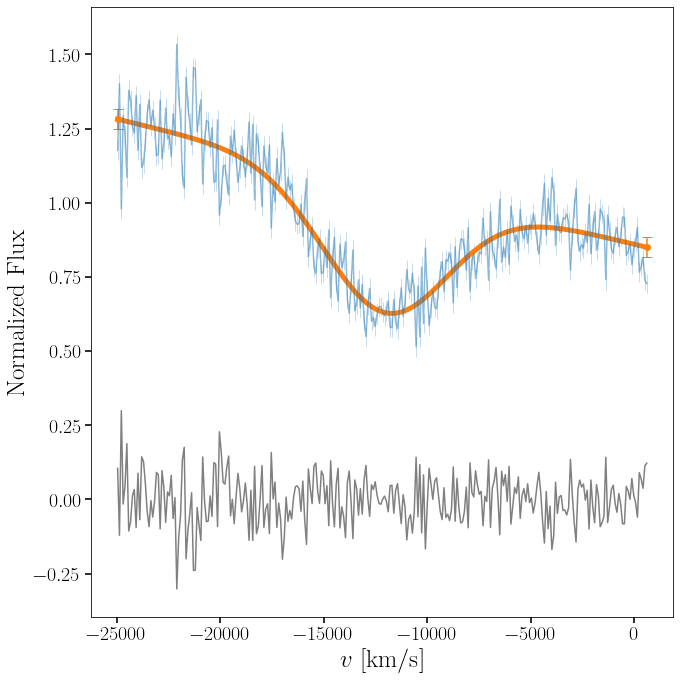

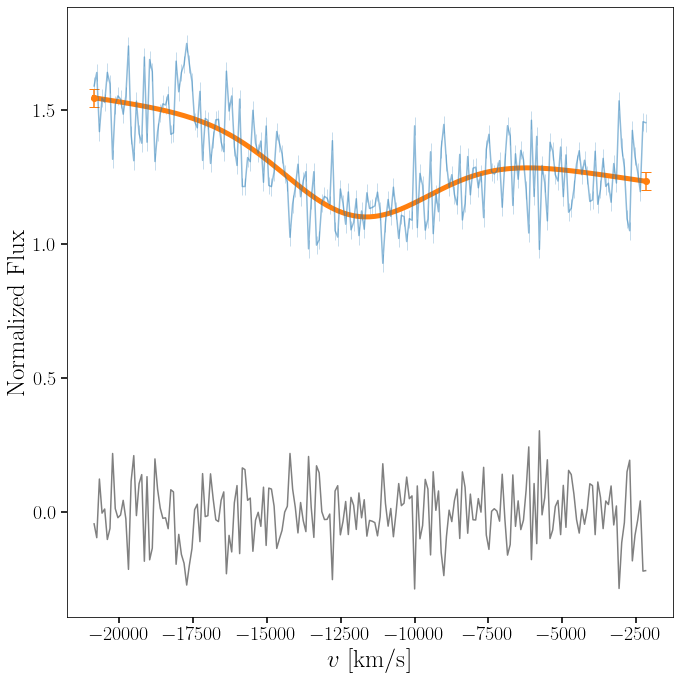

1.0 600000.0 40.0
assign manual snr...
LS estimation:
Velocity 1: -12054 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12077.079  110.948 -12203.613 -11982.191      1.683    1.190   
v_sig[0]    2873.309  120.093   2740.891   2977.699      2.221    1.570   
A[0]       -1825.014   84.131  -1907.893  -1740.061      1.566    1.109   
sigma_0        0.089    0.004      0.084      0.093      0.000    0.000   
EW_0          61.627    2.532     59.107     64.172      0.047    0.033   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4335.885  2975.898  1.001  
v_sig[0]   2925.703  2958.325  1.000  
A[0]       2882.280  2415.881  1.000  
sigma_0    4515.858  2867.833  1.001  
EW_0       2917.040  2622.946  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12240.354  201.574 -12454.271 -12055.871      3.458    2.445   
v_sig[0]    2286.746  179.682   2039.727   2356.321      3.490    2.515   
A[0]        -871.346   82.246   -939.459   -778.847      1.611    1.156   
sigma_0        0.113    0.006      0.107      0.119      0.000    0.000   
EW_0          21.661    1.936     19.312     23.095      0.038    0.027   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3434.837  2589.345  1.000  
v_sig[0]   2745.410  2207.687  1.003  
A[0]       2695.177  2344.431  1.001  
sigma_0    4604.085  2902.334  1.000  
EW_0       2716.649  2353.761  1.001  


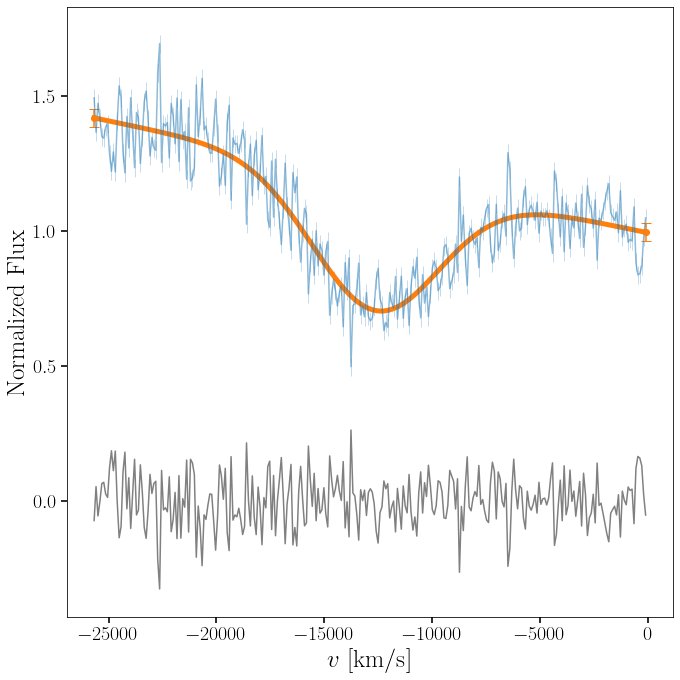

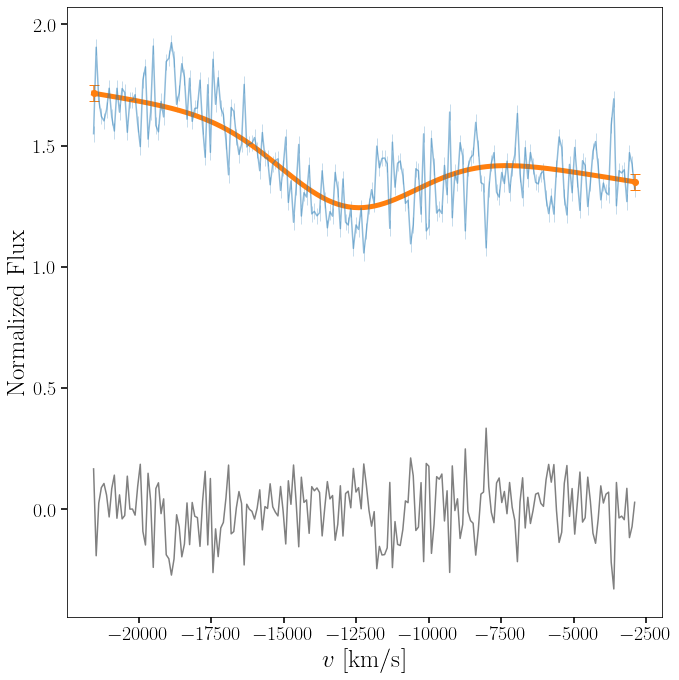

1.0 600000.0 67.0
assign manual snr...
LS estimation:
Velocity 1: -12584 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12557.386  124.205 -12687.560 -12443.511      1.848    1.307   
v_sig[0]    2950.417  135.216   2811.459   3078.516      2.531    1.790   
A[0]       -2372.837  115.819  -2483.763  -2254.491      2.231    1.582   
sigma_0        0.124    0.006      0.118      0.129      0.000    0.000   
EW_0          65.047    2.838     62.197     67.820      0.054    0.038   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4518.636  3196.497  1.001  
v_sig[0]   2856.432  2900.076  1.000  
A[0]       2713.195  3049.696  1.001  
sigma_0    4876.096  3141.928  1.001  
EW_0       2823.391  3204.573  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12807.142  180.225 -13000.347 -12647.424      2.774    1.961   
v_sig[0]    2304.408  167.840   2083.766   2356.278      3.403    2.427   
A[0]       -1141.019  100.396  -1216.264  -1026.417      2.062    1.482   
sigma_0        0.141    0.007      0.133      0.148      0.000    0.000   
EW_0          22.767    1.897     20.698     24.296      0.038    0.028   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4263.645  2978.613  1.003  
v_sig[0]   2337.753  2040.480  1.003  
A[0]       2465.141  2132.127  1.001  
sigma_0    4268.759  2982.624  1.000  
EW_0       2514.906  2095.908  1.001  


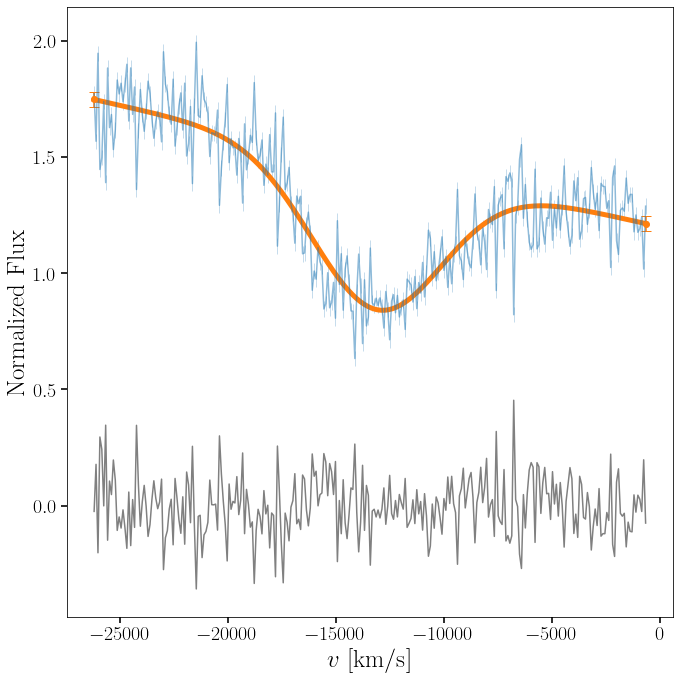

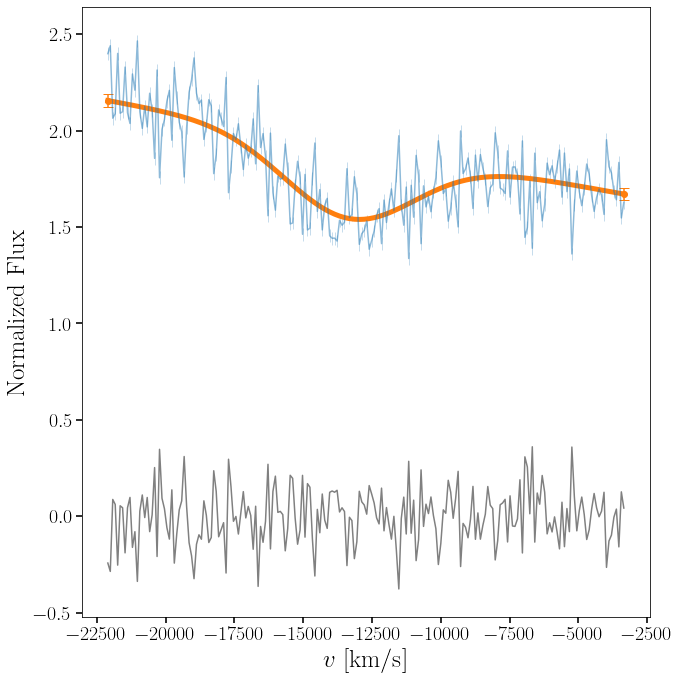

1.0 600000.0 93.0
assign manual snr...
LS estimation:
Velocity 1: -13525 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -13485.219  140.691 -13648.676 -13367.341      2.089    1.478   
v_sig[0]    3049.978  154.316   2884.707   3183.883      2.777    1.967   
A[0]       -2884.637  155.127  -3028.260  -2724.088      3.102    2.195   
sigma_0        0.169    0.008      0.161      0.176      0.000    0.000   
EW_0          65.870    3.177     62.724     68.961      0.062    0.044   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4530.219  3316.907  1.001  
v_sig[0]   3100.758  2826.092  1.002  
A[0]       2507.674  2560.617  1.001  
sigma_0    3833.866  2190.864  1.001  
EW_0       2605.426  2569.339  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -13086.922  226.700 -13287.660 -12844.787      3.364    2.381   
v_sig[0]    2336.639  148.245   2154.184   2375.951      2.420    1.711   
A[0]       -1198.583  121.183  -1319.886  -1080.271      2.149    1.540   
sigma_0        0.200    0.010      0.190      0.209      0.000    0.000   
EW_0          20.805    2.013     18.653     22.632      0.035    0.025   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4492.671  2806.132  1.001  
v_sig[0]   3104.434  2206.590  1.001  
A[0]       3213.214  2779.445  1.000  
sigma_0    4422.130  2864.100  1.001  
EW_0       3243.613  2791.399  1.000  


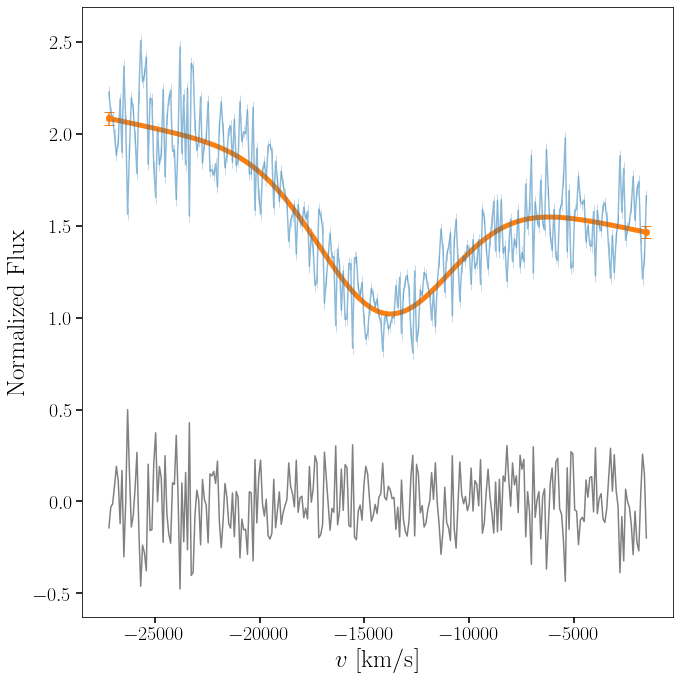

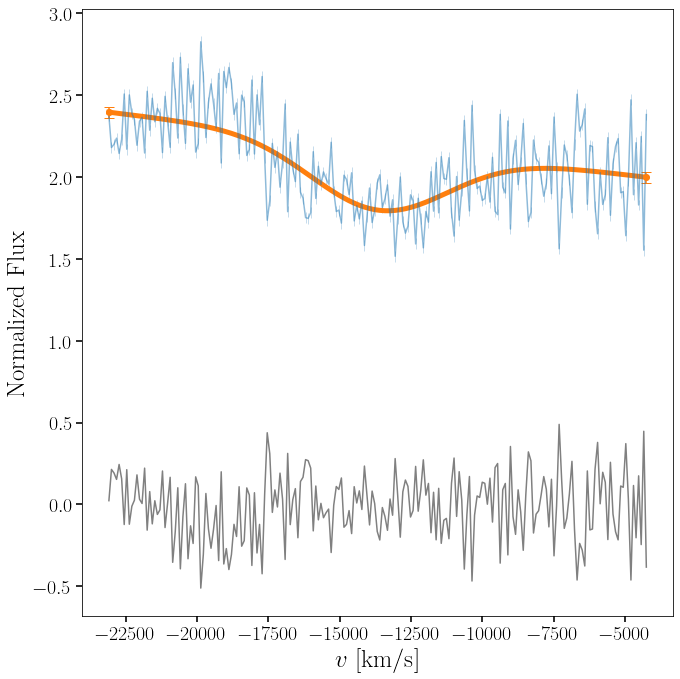

1.1 300000.0 -13.0
assign manual snr...
LS estimation:
Velocity 1: -12806 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12848.730  100.753 -12952.287 -12753.290      1.509    1.067   
v_sig[0]    2565.991  120.894   2438.728   2676.241      2.253    1.594   
A[0]       -1164.225   54.083  -1212.573  -1106.569      1.029    0.729   
sigma_0        0.056    0.003      0.052      0.058      0.000    0.000   
EW_0          54.530    2.293     52.133     56.610      0.043    0.031   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4451.430  2690.275  1.002  
v_sig[0]   2879.096  3015.415  1.001  
A[0]       2766.381  2836.487  1.000  
sigma_0    4457.496  2165.757  1.000  
EW_0       2833.816  2856.257  1.000  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


assign manual snr...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12878.169  175.124 -13042.809 -12698.455      2.750    1.945   
v_sig[0]    2034.791  148.299   1831.806   2104.086      2.782    1.967   
A[0]        -538.492   49.719   -575.126   -477.896      0.938    0.669   
sigma_0        0.070    0.004      0.067      0.075      0.000    0.000   
EW_0          18.257    1.603     16.420     19.562      0.030    0.021   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4060.293  3113.252  1.005  
v_sig[0]   2498.599  2010.560  1.001  
A[0]       2845.483  2576.152  1.002  
sigma_0    4573.043  2799.120  1.001  
EW_0       2867.191  2594.025  1.002  


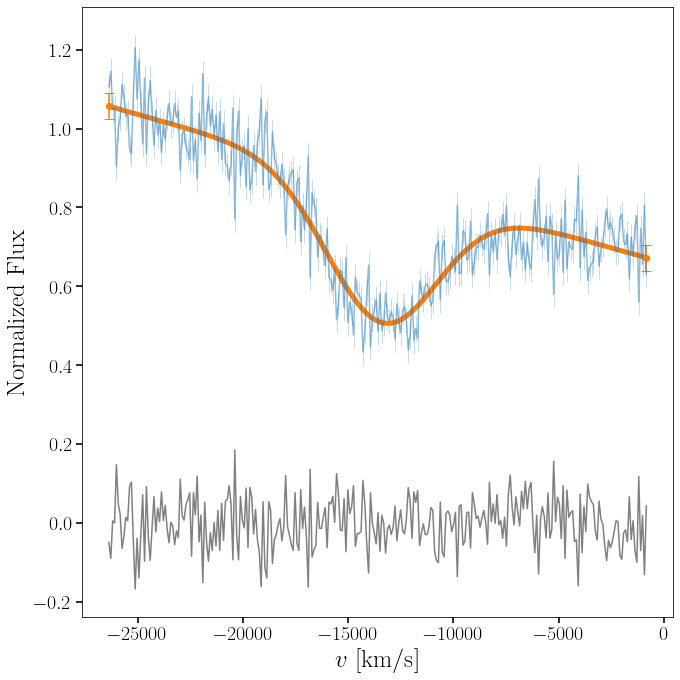

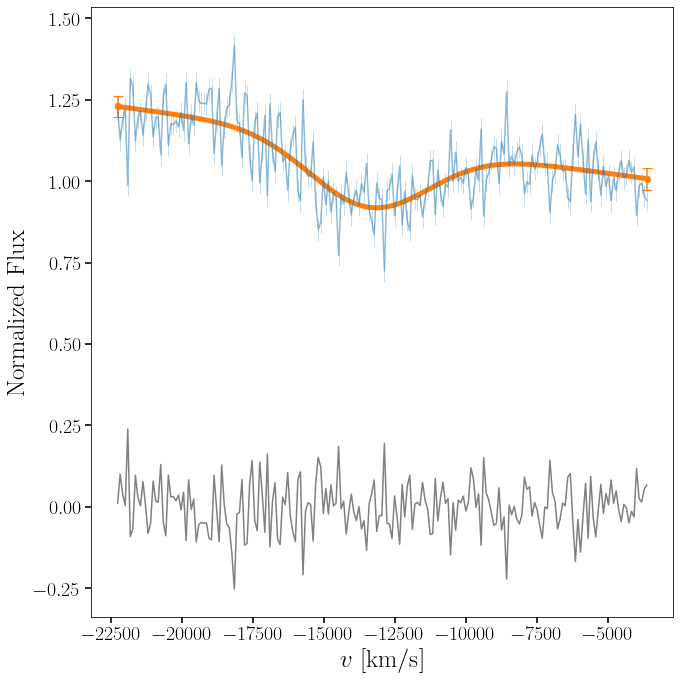

1.1 300000.0 -40.0
assign manual snr...
LS estimation:
Velocity 1: -12134 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12200.861  101.327 -12295.640 -12093.096      1.539    1.088   
v_sig[0]    2459.449  106.283   2361.501   2571.963      1.859    1.316   
A[0]       -1052.768   47.034  -1094.448  -1002.880      0.809    0.574   
sigma_0        0.052    0.003      0.049      0.055      0.000    0.000   
EW_0          54.756    2.218     52.320     56.652      0.038    0.027   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4340.657  2936.012  1.000  
v_sig[0]   3270.481  3011.332  1.000  
A[0]       3363.370  2937.845  1.000  
sigma_0    4341.948  2917.180  1.001  
EW_0       3474.985  2962.790  0.999  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12530.897  155.397 -12686.969 -12378.036      2.420    1.714   
v_sig[0]    2056.407  164.682   1852.620   2185.787      3.025    2.140   
A[0]        -583.844   52.477   -631.723   -528.325      1.026    0.740   
sigma_0        0.064    0.004      0.059      0.067      0.000    0.000   
EW_0          21.654    1.839     19.773     23.392      0.036    0.026   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4131.305  3220.510  1.000  
v_sig[0]   2873.486  2567.708  1.002  
A[0]       2640.605  2776.110  1.002  
sigma_0    4315.980  2717.827  1.003  
EW_0       2683.734  2767.613  1.002  


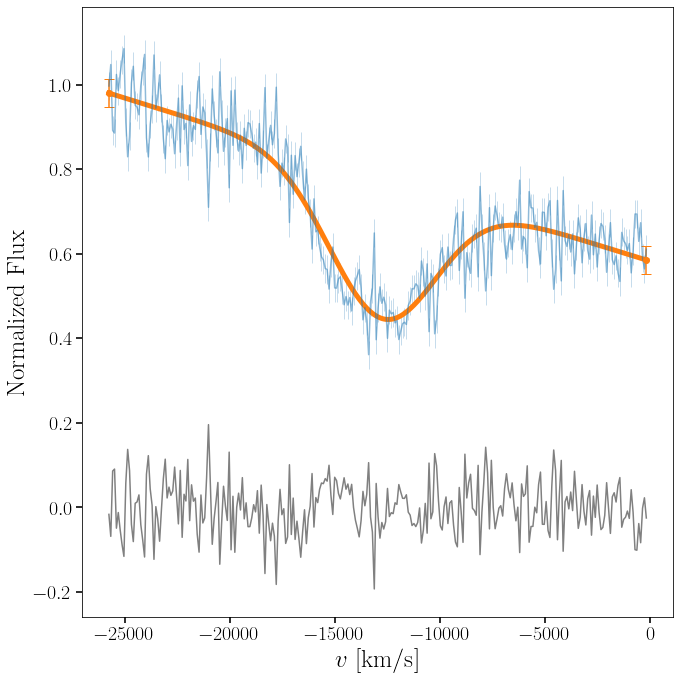

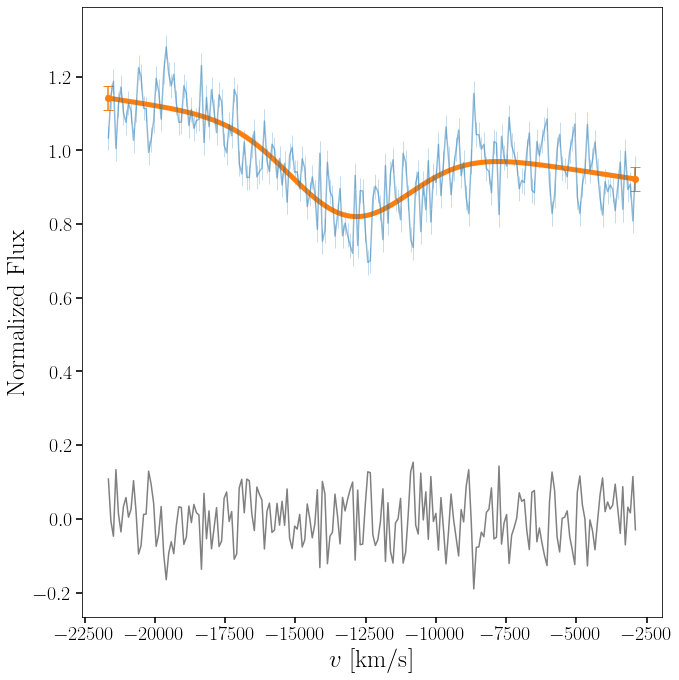

1.1 300000.0 -67.0
assign manual snr...
LS estimation:
Velocity 1: -11575 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11609.954  102.568 -11716.019 -11509.660      1.652    1.168   
v_sig[0]    2339.866  126.422   2223.364   2472.639      2.299    1.626   
A[0]        -887.416   45.731   -932.680   -841.325      0.889    0.629   
sigma_0        0.045    0.003      0.042      0.048      0.000    0.000   
EW_0          48.871    2.296     46.618     51.223      0.044    0.031   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3863.788  2947.726  1.000  
v_sig[0]   3029.912  3189.369  1.001  
A[0]       2639.443  2897.805  1.003  
sigma_0    4702.833  2626.343  1.000  
EW_0       2704.935  3019.161  1.003  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12351.519  176.116 -12519.411 -12174.153      2.822    1.996   
v_sig[0]    1958.217  183.089   1714.881   2074.528      3.641    2.576   
A[0]        -452.259   47.072   -491.034   -399.616      0.898    0.640   
sigma_0        0.060    0.004      0.056      0.063      0.000    0.000   
EW_0          17.213    1.710     15.276     18.615      0.032    0.023   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3908.083  2818.902  1.001  
v_sig[0]   2317.414  2022.452  1.002  
A[0]       2784.510  2728.611  1.001  
sigma_0    3997.127  3039.939  1.000  
EW_0       2811.730  2757.397  1.001  


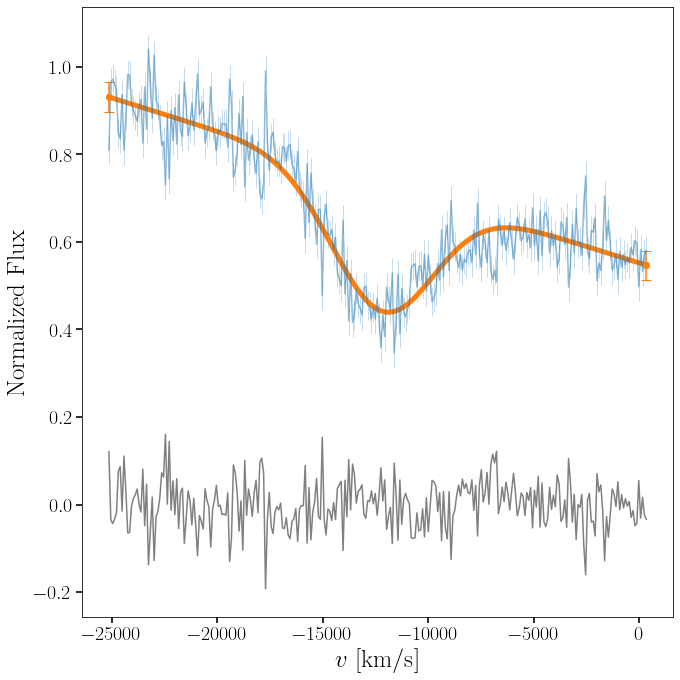

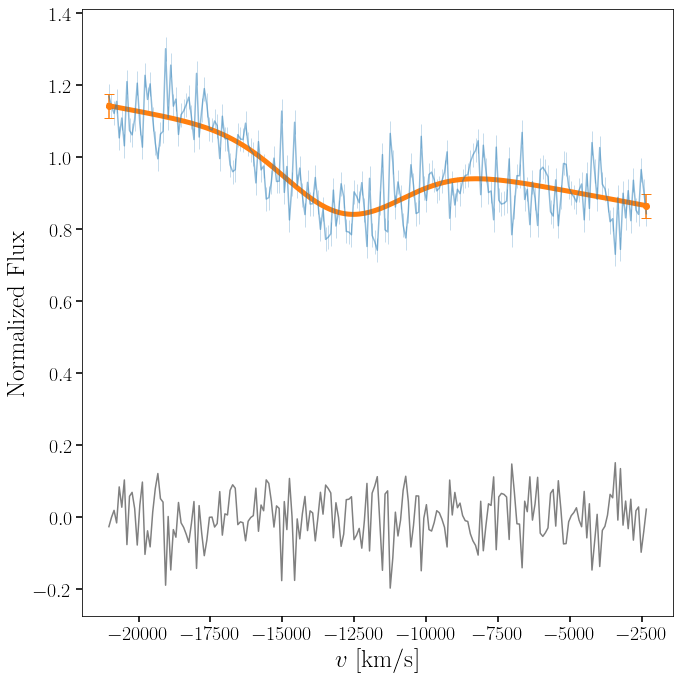

1.1 300000.0 -93.0
assign manual snr...
LS estimation:
Velocity 1: -11697 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -11777.315  126.830 -11893.082 -11641.313      2.056    1.454   
v_sig[0]    2578.588  156.531   2421.150   2723.718      2.981    2.113   
A[0]        -836.446   49.098   -892.806   -794.144      0.953    0.676   
sigma_0        0.046    0.003      0.043      0.049      0.000    0.000   
EW_0          46.036    2.478     43.563     48.522      0.048    0.034   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3843.791  2763.746  1.000  
v_sig[0]   2769.576  2551.363  1.000  
A[0]       2652.911  2505.124  1.001  
sigma_0    4081.782  2504.662  1.001  
EW_0       2711.846  2513.764  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -12021.007  228.165 -12223.736 -11771.892      3.807    2.697   
v_sig[0]    2463.547  215.638   2314.620   2753.426      4.204    2.983   
A[0]        -485.544   57.104   -539.952   -426.557      1.163    0.822   
sigma_0        0.060    0.004      0.056      0.064      0.000    0.000   
EW_0          18.441    2.066     16.249     20.373      0.042    0.030   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3608.044  2410.233  1.001  
v_sig[0]   2277.888  1974.615  1.001  
A[0]       2410.375  2659.536  1.001  
sigma_0    4049.018  2192.218  1.003  
EW_0       2432.682  2775.633  1.001  


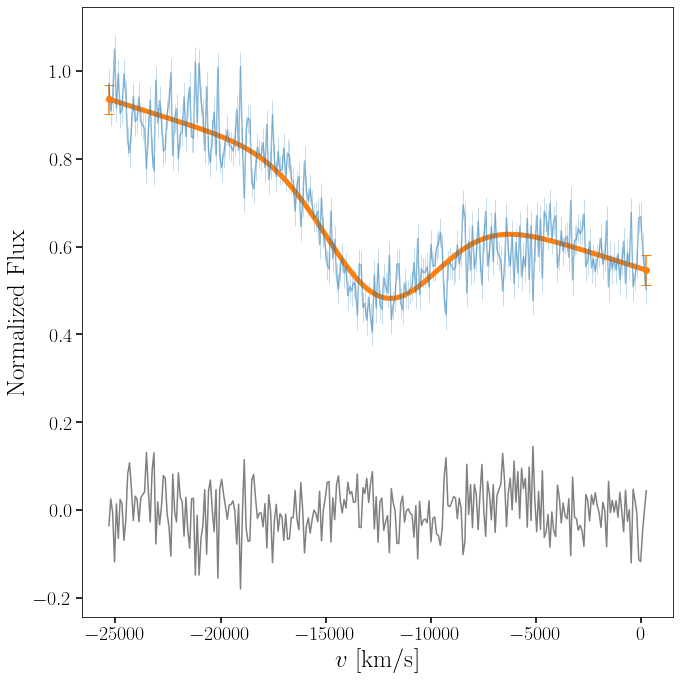

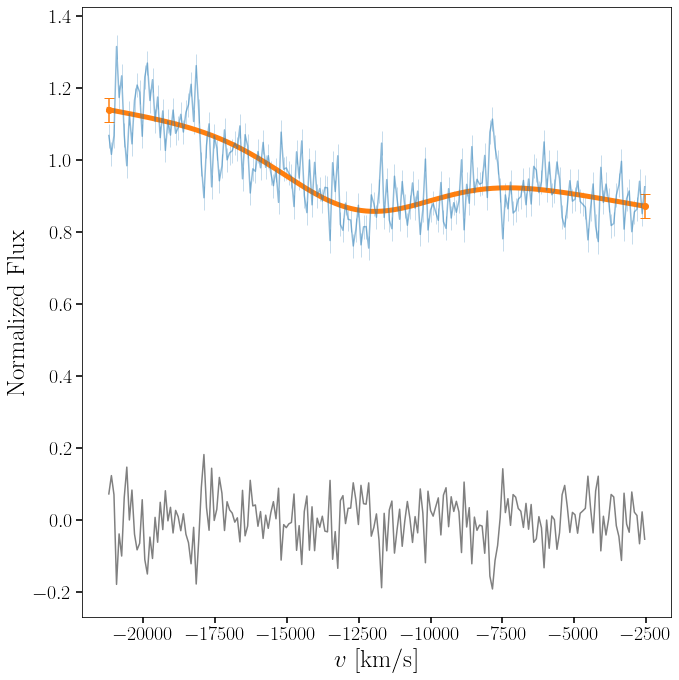

1.1 300000.0 13.0
assign manual snr...
LS estimation:
Velocity 1: -13912 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -13937.159  112.814 -14051.897 -13824.946      1.712    1.211   
v_sig[0]    3055.744  128.800   2934.223   3189.587      2.490    1.761   
A[0]       -1584.539   73.605  -1654.823  -1512.747      1.429    1.013   
sigma_0        0.068    0.004      0.064      0.071      0.000    0.000   
EW_0          65.174    2.674     62.635     67.813      0.051    0.036   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4336.647  2943.611  1.002  
v_sig[0]   2677.460  2512.518  1.001  
A[0]       2674.161  2465.994  1.000  
sigma_0    4418.175  2809.738  1.001  
EW_0       2726.792  2692.995  1.000  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -13173.967  209.129 -13367.512 -12955.903      3.510    2.484   
v_sig[0]    2392.630  185.473   2159.215   2443.771      3.327    2.366   
A[0]        -643.614   68.033   -695.582   -567.824      1.317    0.945   
sigma_0        0.087    0.005      0.082      0.092      0.000    0.000   
EW_0          19.502    1.957     17.493     21.187      0.038    0.027   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3549.577  3055.463  1.000  
v_sig[0]   3049.723  2314.464  1.001  
A[0]       2774.872  2440.394  1.000  
sigma_0    3350.719  2215.167  1.001  
EW_0       2811.395  2536.437  1.000  


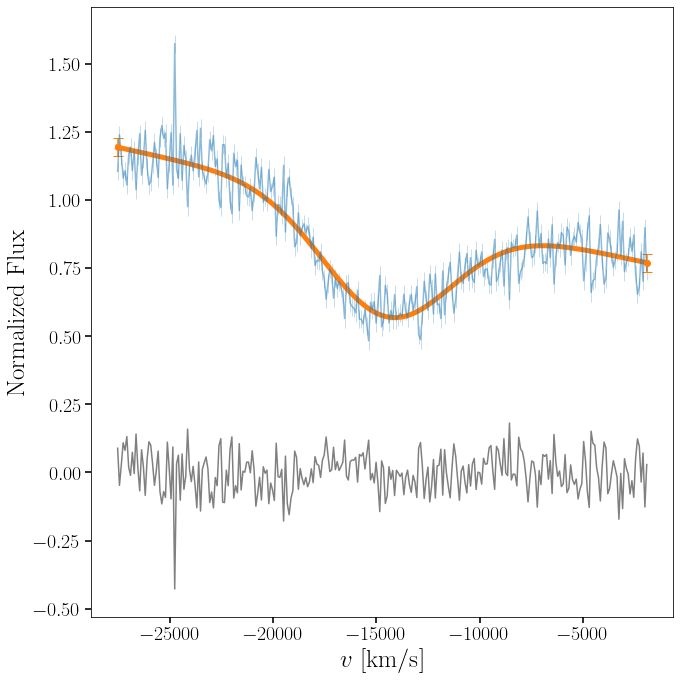

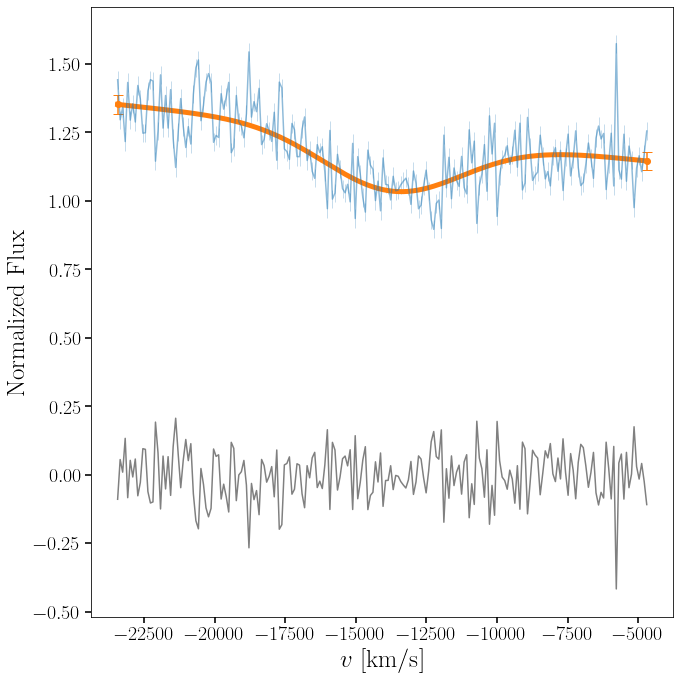

1.1 300000.0 40.0
assign manual snr...
LS estimation:
Velocity 1: -15440 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -15463.598  125.553 -15600.357 -15351.823      2.004    1.417   
v_sig[0]    2977.349  139.302   2832.862   3102.648      2.544    1.802   
A[0]       -1503.823   76.749  -1577.637  -1427.945      1.487    1.055   
sigma_0        0.075    0.004      0.071      0.079      0.000    0.000   
EW_0          63.022    2.868     60.266     65.913      0.055    0.039   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3936.371  3102.724  1.001  
v_sig[0]   3006.441  2812.093  1.001  
A[0]       2669.774  2494.856  1.000  
sigma_0    4172.347  2795.369  1.003  
EW_0       2749.074  2623.540  1.000  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


assign manual snr...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -14389.213  379.546 -14747.342 -14004.656      6.205    4.388   
v_sig[0]    2425.076  252.214   2102.906   2509.910      4.026    2.886   
A[0]        -317.773   69.458   -380.369   -245.234      1.311    0.927   
sigma_0        0.100    0.006      0.094      0.104      0.000    0.000   
EW_0           9.687    2.067      7.693     11.720      0.039    0.028   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3747.394  3003.029  1.001  
v_sig[0]   3731.814  2590.914  1.002  
A[0]       2804.966  2248.154  1.000  
sigma_0    4163.483  2852.004  1.001  
EW_0       2823.688  2308.453  1.000  


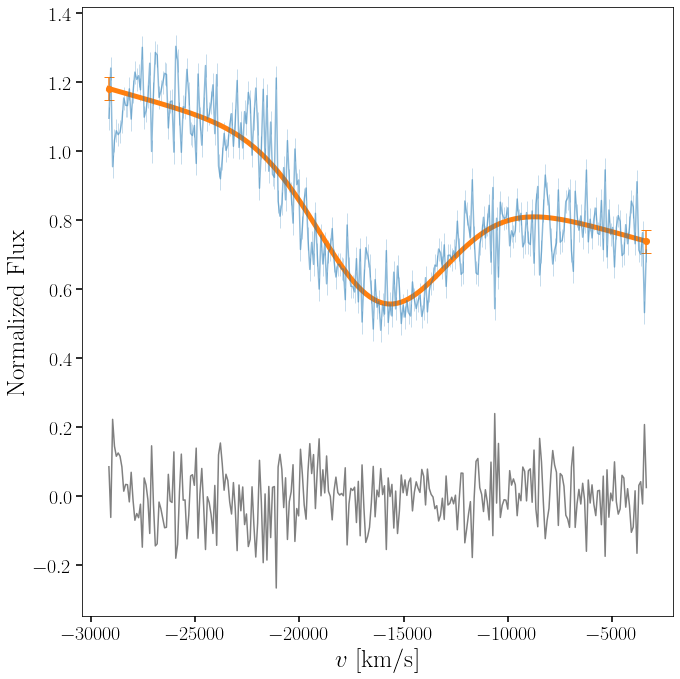

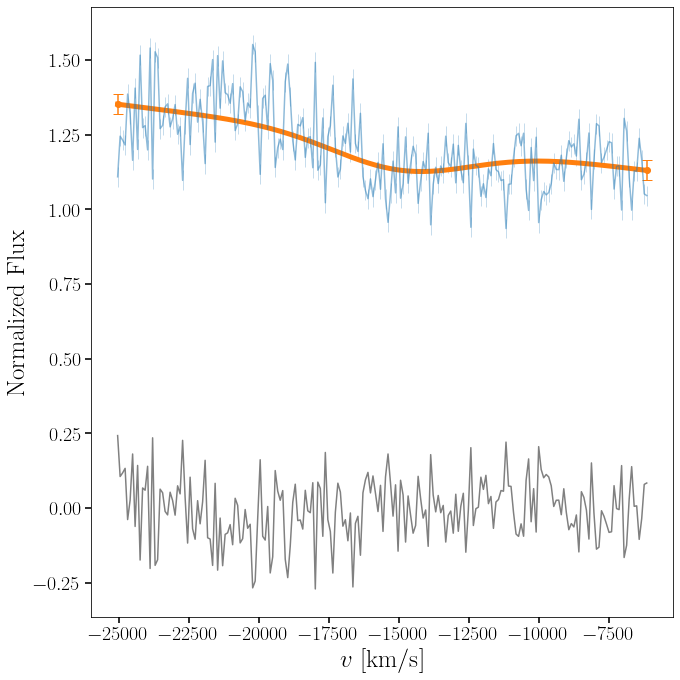

1.1 300000.0 67.0
assign manual snr...
LS estimation:
Velocity 1: -17167 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -17201.028  119.961 -17320.807 -17084.872      1.995    1.411   
v_sig[0]    3255.078  142.673   3122.257   3402.052      2.926    2.072   
A[0]       -2220.553  107.224  -2321.446  -2109.591      2.233    1.580   
sigma_0        0.097    0.005      0.092      0.102      0.000    0.000   
EW_0          72.018    3.042     68.835     74.854      0.062    0.044   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3615.110  2901.239  1.000  
v_sig[0]   2382.829  2587.038  1.001  
A[0]       2312.445  2597.483  1.001  
sigma_0    3465.048  2682.496  1.001  
EW_0       2405.939  2654.866  1.001  


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")


assign manual snr...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -16012.832  410.396 -16388.895 -15582.757      7.264    5.158   
v_sig[0]    2555.407  244.914   2299.480   2595.817      4.024    2.922   
A[0]        -398.163   95.650   -486.918   -300.839      1.835    1.297   
sigma_0        0.137    0.007      0.129      0.144      0.000    0.000   
EW_0           9.452    2.224      7.198     11.507      0.043    0.030   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3278.124  2437.853  1.000  
v_sig[0]   3918.442  2083.994  1.002  
A[0]       2749.155  2016.829  1.001  
sigma_0    4189.704  3025.693  1.000  
EW_0       2766.387  2009.696  1.001  


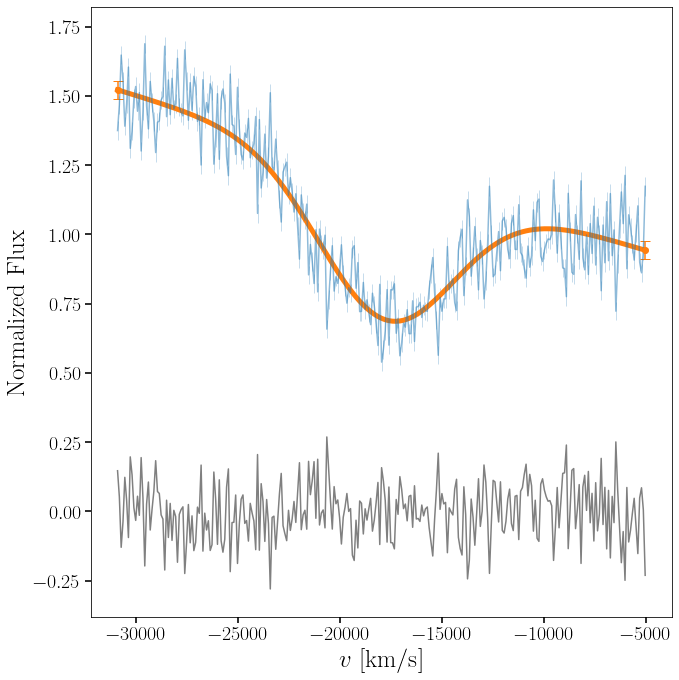

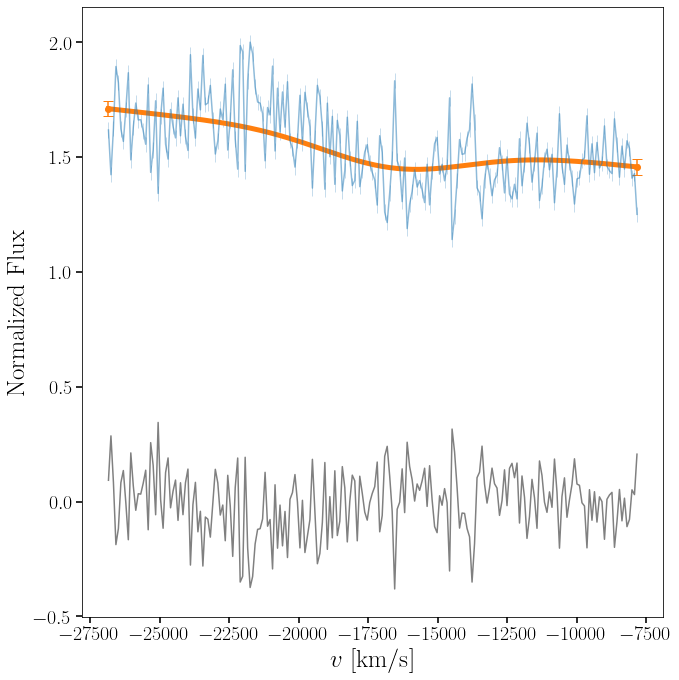

1.1 300000.0 93.0
assign manual snr...
LS estimation:
Velocity 1: -18969 km/s
assign manual snr...
30


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -18878.158  103.524 -18975.542 -18772.025      1.591    1.125   
v_sig[0]    3419.350  113.594   3308.653   3532.575      2.344    1.658   
A[0]       -3393.017  131.776  -3518.720  -3260.920      2.798    1.979   
sigma_0        0.119    0.005      0.114      0.124      0.000    0.000   
EW_0          88.764    2.936     86.077     91.801      0.061    0.043   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  4277.830  3345.782  1.001  
v_sig[0]   2343.880  2607.888  1.000  
A[0]       2205.505  2361.944  1.001  
sigma_0    4410.394  2852.957  1.002  
EW_0       2296.179  2465.051  1.001  
assign manual snr...


/Users/chang/Desktop/SN2022joj/photometry/../spectroscopy/absorption_line_vel.py:92: UserWarning: No flux uncertainty in the datafile!
  warnings.warn("No flux uncertainty in the datafile!")
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6059, but should be close to 0.8. Try to increase the number of tuning steps.


                mean       sd    hdi_16%    hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -18161.719  549.824 -18763.974 -17639.141     12.247    8.661   
v_sig[0]    2987.392  366.159   2416.165   3168.494      6.759    4.817   
A[0]        -286.349  116.578   -391.846   -157.328      2.972    2.102   
sigma_0        0.151    0.008      0.144      0.158      0.000    0.000   
EW_0           5.647    2.273      3.281      7.860      0.058    0.041   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2013.677  2078.076  1.001  
v_sig[0]   2681.351  2117.044  1.001  
A[0]       1459.797  1187.342  1.001  
sigma_0    2884.606  2776.530  1.002  
EW_0       1469.038  1191.399  1.001  


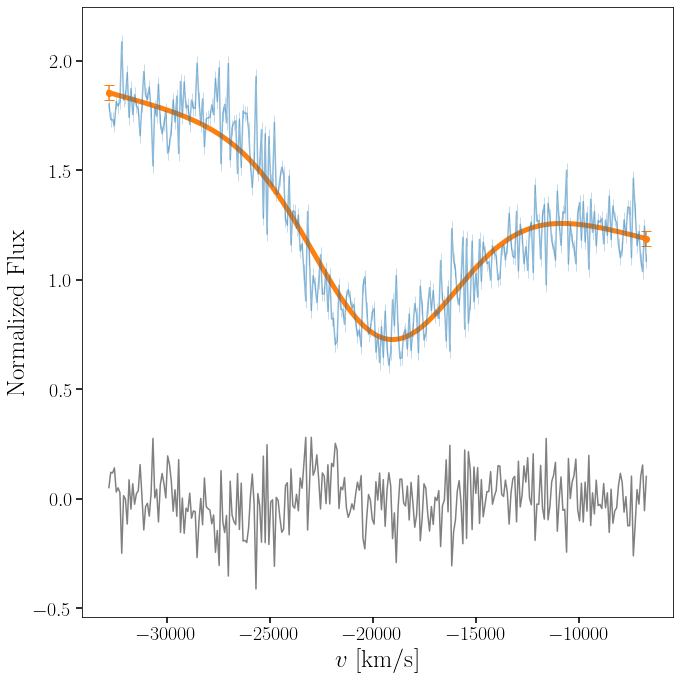

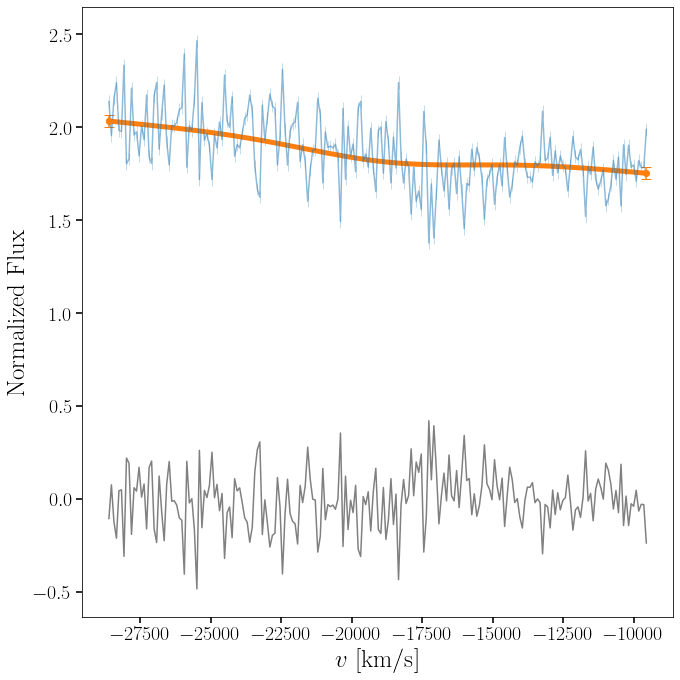

In [14]:
syn_mc = np.empty_like(synth_spec, dtype=float)
syn_rho = np.empty_like(synth_spec, dtype=float)
syn_mu = np.empty_like(synth_spec, dtype=float)
v_Si_Shen = np.empty_like(synth_spec, dtype=float)
v_Si_err_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_6355_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_5972_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_6355_err_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_5972_err_Shen = np.empty_like(synth_spec, dtype=float)

for k in range(len(synth_spec)):
    syn_mc[k] = float(synth_spec[k].split('_')[2])
    syn_rho[k] = float(synth_spec[k].split('_')[4])
    syn_mu[k] = float(synth_spec[k].split('_')[6])
    print(syn_mc[k], syn_rho[k], syn_mu[k])
    Spec = SpectrumSN_Lines(synth_spec[k], z=z, snr=30)
    Spec.add_line("SiII0", 5750, 6450, lines=[6371.359, 6347.103])
    Spec.line["SiII0"].LS_estimator()
    v_temp = Spec.line["SiII0"].theta_LS[2]

    Spec.add_line(
        "SiII_6355",
        lambda_rf(6347.103, v_temp) - 250,
        lambda_rf(6371.359, v_temp) + 250,
        lines=[6371.359, 6347.103],
    )
    print(Spec.snr)
    try:
        Spec.line["SiII_6355"].MCMC_sampler(
            vel_mean_mu=[-1e4],
            vel_mean_sig=[3e3],
            initial=Spec.line["SiII0"].theta_LS,
            vel_var_lim=[1e4, 1e10],
            A_lim=[-1e6, 0],
        )
    except:
        print(Spec.line["SiII0"].theta_LS)
        break
    v_Si_Shen[k] = Spec.line["SiII_6355"].theta_MCMC[2]

    Spec.add_line(
        "SiII_5972",
        lambda_rf(5957.561, v_temp) - 160,
        lambda_rf(5978.929, v_temp) + 180,
        lines=[5957.561, 5978.929],
    )
    vel_var_6355 = np.exp(Spec.line["SiII_6355"].theta_MCMC[3])
    Spec.line["SiII_5972"].MCMC_sampler(
        vel_mean_mu=[v_Si_Shen[k]],
        vel_mean_sig=[5e2],
        initial=Spec.line["SiII_6355"].theta_MCMC,
        vel_var_lim=[vel_var_6355 / 2, vel_var_6355 * 1.2],
        A_lim=[-1e6, 0],
    )

    EW_Si_6355_Shen[k], EW_Si_5972_Shen[k] = (
        Spec.line["SiII_6355"].EW[0],
        Spec.line["SiII_5972"].EW[0],
    )
    EW_Si_6355_err_Shen[k], EW_Si_5972_err_Shen[k] = (
        Spec.line["SiII_6355"].sig_EW[0],
        Spec.line["SiII_5972"].sig_EW[0],
    )
    # if (
    #     np.abs(
    #         Spec.line["SiII_5972"].theta_MCMC[2] - Spec.line["SiII_6355"].theta_MCMC[2]
    #     )
    #     > 2000
    # ):
    #     EW_Si_5972_Shen[k] = np.nan
    # if np.abs(syn_mu[k]) >= 90:
    #     EW_Si_6355_Shen[k], EW_Si_5972_Shen[k], v_Si_Shen[k] = np.nan, np.nan, np.nan
    plt.show()

In [15]:
M_B_max_Shen = np.empty_like(synth_lc, dtype=float)

for k in range(len(synth_lc)):
    lc = np.loadtxt(synth_lc[k])
    M_B = lc[:, -1]
    M_B_max_Shen[k] = M_B.min()

In [16]:
np.savetxt(
    fname="./Shen+21_model/1.1Msun_spec_para.dat",
    X=np.array(
        [
            syn_mc,
            syn_mu / 100,
            syn_rho,
            M_B_max_Shen,
            v_Si_Shen,
            v_Si_err_Shen,
            EW_Si_5972_Shen,
            EW_Si_5972_err_Shen,
            EW_Si_6355_Shen,
            EW_Si_6355_err_Shen,
        ]
    ).T,
    fmt="%.1f %.2f %.0f %.3f %.3f %.3f %.3f %.3f %.3f %.3f",
    header="m mu density M_B_max v_Si v_Si_err EW_Si_5972 EW_Si_5972_err EW_Si_6355 EW_Si_6355_err",
)

## Model comparison plot

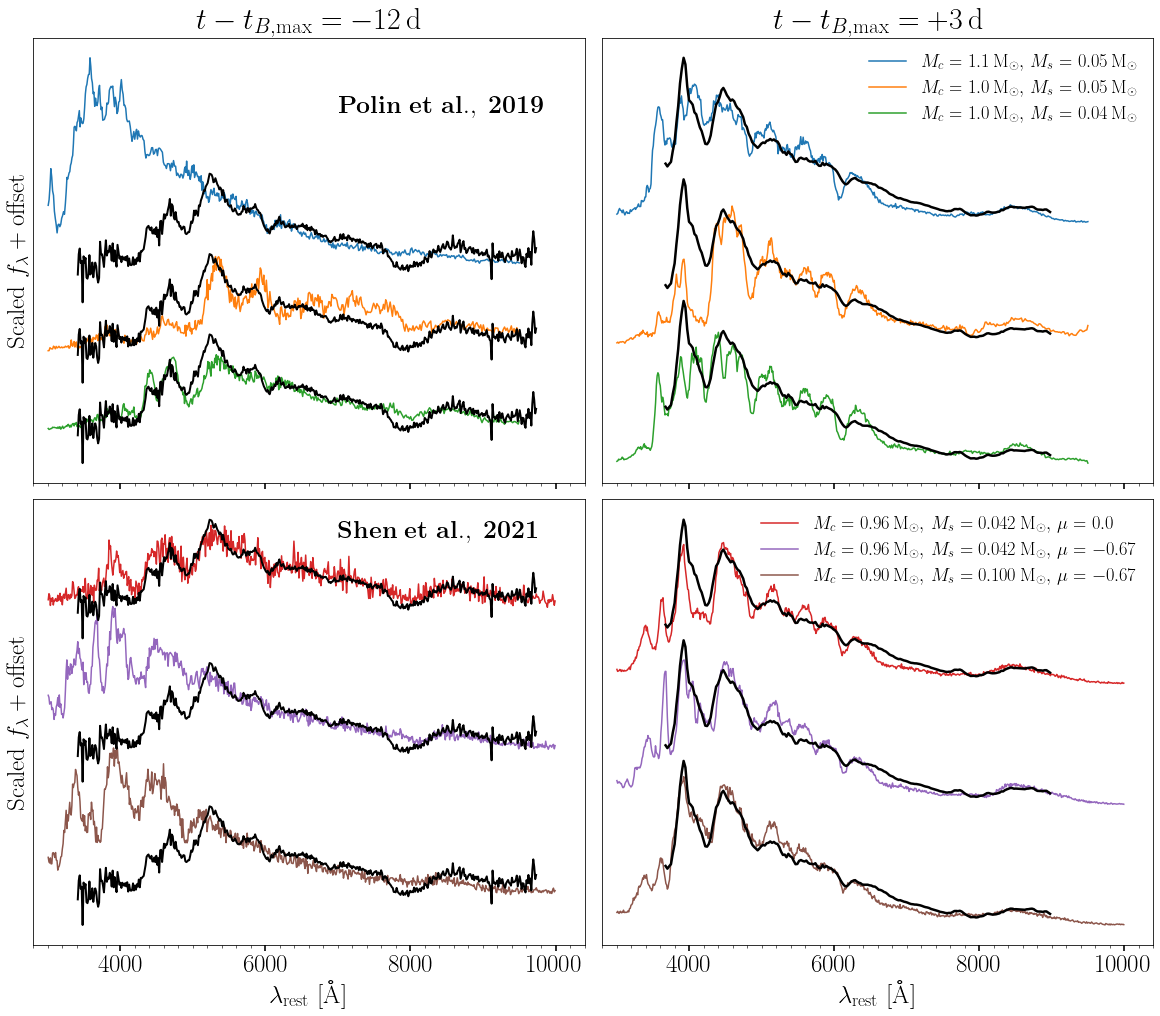

In [36]:
# prop_cycle = plt.rcParams["axes.prop_cycle"]
import seaborn as sns

colors = sns.color_palette()

fig, axes = plt.subplots(2, 2, figsize=(16, 14), sharex=True, constrained_layout=True)

h0 = np.array([[1.5, 2.1], [2.9, 2.1]])

# Polin+2019 models
ax = axes[0]
models_Polin = sorted(glob.glob("./Polin+19_model/*1*phase*spec*"), reverse=True)
k = -1
for model in models_Polin:
    mc = float(model.split("_")[2])
    ms = float(model.split("_")[4])
    if (ms >= 0.06) or (ms <= 0.03) or (mc > 1.1):
        continue
    phase = float(model.split("_")[-2])
    if phase == -11:
        a = ax[0]
        h = h0[0, 0]
    elif phase == 2:
        a = ax[1]
        k += 1
        h = h0[0, 1]
    else:
        continue
    dat = np.loadtxt(model)
    dat = data_binning(
        np.array([dat[:, 0], dat[:, 1], np.ones_like(dat[:, 0])]).T, size=10
    )
    a.plot(
        dat[:, 0] / (1 + z),
        dat[:, 1] / np.median(dat[(dat[:, 0] > 5800) & (dat[:, 0] < 6500), 1]) - k * h,
        label=f"$M_c = {mc}\,"
        + r"\mathrm{M_\odot},\,"
        + f"M_s = {ms}\,"
        + r"\mathrm{M_\odot}$",
        color=colors[k],
    )

# Shen+2021 models
ax = axes[1]
models_Shen = sorted(
    glob.glob("./Shen+21_model/*-67*phase*spec*")
    + glob.glob("./Shen+21_model/*6e5*_0_*phase*spec*"),
    reverse=True,
)

k = -1
mc_shen = [0.96, 0.96, 0.90]
ms_shen = [0.042, 0.042, 0.100]
for model in models_Shen:
    mc = float(model.split("_")[2])
    dens = int(float(model.split("_")[4]) / 1e5)
    phase = float(model.split("_")[-2])
    mu = float(model.split("_")[-4])
    if mc > 1:
        continue
    if phase == -11:
        a = ax[0]
        h = h0[1, 0]
    elif phase == 3:
        a = ax[1]
        h = h0[1, 1]
        k += 1
    else:
        continue
    dat = np.loadtxt(model)
    dat = data_binning(
        np.array([dat[:, 0], dat[:, 1], np.ones_like(dat[:, 0])]).T, size=10
    )
    a.plot(
        dat[:, 0] / (1 + z),
        dat[:, 1] / np.median(dat[(dat[:, 0] > 5800) & (dat[:, 0] < 6500), 1]) - k * h,
        # label=f"$M = {mc}\,"
        # + r"\mathrm{M_\odot},\ "
        # + rf"\rho_5 = {dens},\ \mu = {mu/100}$",
        label=r"$M_c = {:.2f}\,".format(mc_shen[k])
        + r"\mathrm{M_\odot},\,"
        + r"M_s = {:.3f}\,".format(ms_shen[k])
        + r"\mathrm{M_\odot},\,"
        + rf"\mu = {mu/100}$",
        zorder=int(dens),
        lw=1.5,
        color=colors[k + 3],
    )
    a.set_xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")

axes[0, 1].legend(prop={"size": 18.5}, frameon=False)
axes[1, 1].legend(prop={"size": 18.5}, frameon=False)

for i, (a, l) in enumerate(zip(axes[:, 0], [3, 3])):
    spec1_bin = data_binning(spec1, size=10)
    for k in range(l):
        a.plot(
            spec1_bin[:, 0] / (1 + z),
            spec1_bin[:, 1]
            / np.median(spec1[(spec1[:, 0] > 5800) & (spec1[:, 0] < 6500), 1])
            - k * h0[i, 0],
            color="k",
            zorder=100,
            lw=2,
        )
    a.set_ylabel(r"$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$")
for i, (a, l) in enumerate(zip(axes[:, 1], [3, 3])):
    for k in range(l):
        a.plot(
            spec2[:, 0] / (1 + z),
            spec2[:, 1]
            / np.median(spec2[(spec2[:, 0] > 5800) & (spec2[:, 0] < 6500), 1])
            - k * h0[i, 1],
            color="k",
            zorder=100,
            lw=2.5,
        )

# axes[0, 0].set_ylim(-0.3, 3.5)
# axes[0, 1].set_ylim(-0.1, 3)

for a in axes.ravel():
    a.set_yticks([])
    a.xaxis.set_minor_locator(MultipleLocator(200))

axes[0, 0].set_xlim(2800, 10400)

axes[0, 0].set_title(r"$t - t_{B,\mathrm{max}} = -12\,\mathrm{d}$", pad=10)
axes[0, 1].set_title(r"$t - t_{B,\mathrm{max}} = +3\,\mathrm{d}$", pad=10)
axes[0, 0].text(7000, 3, r"$\mathbf{Polin\ et\ al.,\ 2019}$")
axes[1, 0].text(7000, 1.5, r"$\mathbf{Shen\ et\ al.,\ 2021}$")

plt.savefig("../paper/figures/model_comparison_spec.pdf", bbox_inches="tight")

In [16]:
model = '/Users/chang/Desktop/SNIa/Shen2021/1.0_14e5.h5'
m_tot = float(model.split("/")[-1].split("_")[0])
rho = float(model.split("_")[-1].split(".")[0][:-2])
print(m_tot, rho)

with h5py.File(model, "r") as f:
    rho = model.split("_")[-1].split(".")[0][:-2]
    cos_theta = np.array(f["mu"])
    Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
    Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
    time = np.array(f["time"][:] / 86400)
    nu = np.array(f["nu"][:])
    wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
    wv = wv0 * (1 + z)
    E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
    E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
    Flam = [
        np.array(
            [
                (np.flip(fnu[:, i])).to(
                    u.erg / u.s / u.cm**2 / u.AA,
                    equivalencies=u.spectral_density(wv * u.AA),
                )
                for fnu in Fnu
            ]
        )
        / (1 + z)
        * E_Gal
        * E_Host
        for i in np.arange(len(cos_theta))
    ]

1.0 14.0


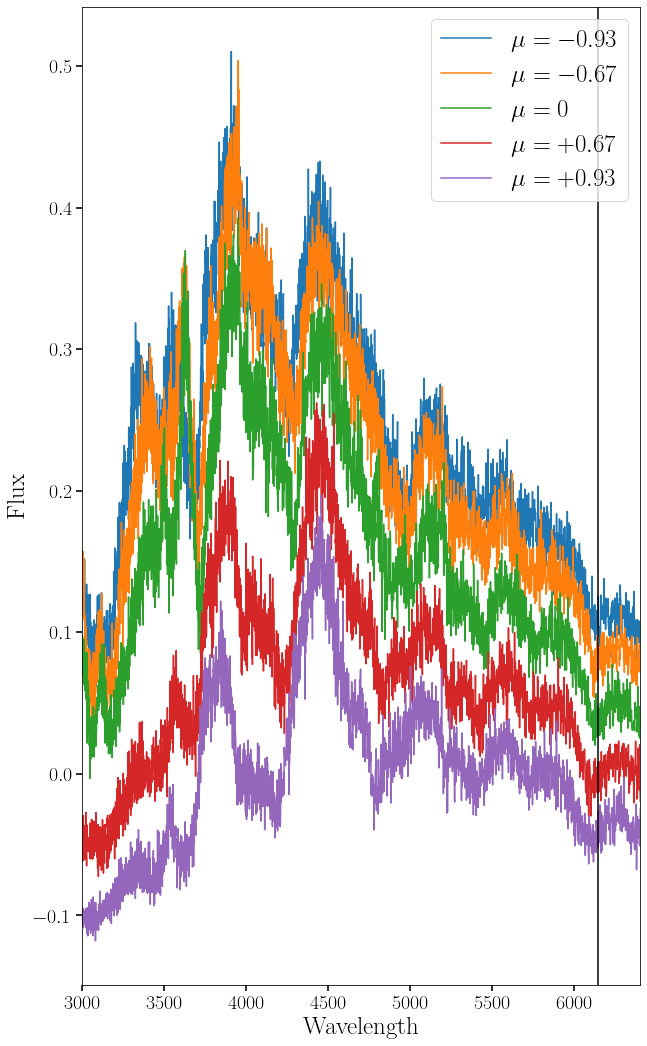

In [59]:
plt.figure(figsize=(10, 18))

dat0 = np.loadtxt("./Shen+21_model/m_1.0_dens_14e5_mu_0_phase_0_spec.txt")
dat1 = np.loadtxt("./Shen+21_model/m_1.0_dens_14e5_mu_-67_spec.txt")
dat2 = np.loadtxt("./Shen+21_model/m_1.0_dens_14e5_mu_67_spec.txt")
dat3 = np.loadtxt("./Shen+21_model/m_1.0_dens_14e5_mu_-93_spec.txt")
dat4 = np.loadtxt("./Shen+21_model/m_1.0_dens_14e5_mu_93_spec.txt")

plt.plot(dat3[:, 0] / (1 + 0.02736), dat3[:, 1], label=r'$\mu=-0.93$')
plt.plot(dat1[:, 0] / (1 + 0.02736), dat1[:, 1] - 0.03 * 1, label=r'$\mu=-0.67$')
plt.plot(dat0[:, 0] / (1 + 0.02736), dat0[:, 1] - 0.03 * 2, label=r'$\mu=0$')
plt.plot(dat2[:, 0] / (1 + 0.02736), dat2[:, 1] - 0.03 * 3, label=r'$\mu=+0.67$')
plt.plot(dat4[:, 0] / (1 + 0.02736), dat4[:, 1] - 0.03 * 4, label=r'$\mu=+0.93$')
# plt.plot(wv0, Flam[np.argmin((cos_theta + 0.67) ** 2)][time == 14.75].ravel())

plt.xlim(3000, 6400)
# plt.ylim(-0.07, 0.18)

# plt.axvline(6355 * ((1 - 1.1 / 30) / (1 + 1.1 / 30)) ** 0.5, color='k')
plt.axvline(6355 * ((1 - 1 / 30) / (1 + 1 / 30)) ** 0.5, color='k')
# plt.axvline(6355 * ((1 - .9 / 30) / (1 + .9 / 30)) ** 0.5, color='k')
# plt.axvline(6355 * (1 - 1.1 / 30), color="k")
plt.ylabel("Flux")
plt.xlabel("Wavelength")
plt.legend()